In [104]:
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [113]:
%config InlineBackend.figure_format = "retina"

In [2]:
ds = sc.read_h5ad('/projects/b1196/ewa_group/serniczek/data/02b_integration/09_raw/09_raw.h5ad')

In [3]:
ds

AnnData object with n_obs × n_vars = 2452841 × 19488
    obs: 'name', 'library_id', 'individual', 'protocol', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', '_scvi_batch', '_scvi_labels', 'Level_1', 'Level_2', 'Level_3', 'Level_4', 'Level_5', 'Level_6', 'ICU_stay', 'ICU_day', 'day_bucket_starts', 'Episode_id', 'bal_barcode', 'Binary_outcome', 'Discharge_disposition', 'Episode_etiology', 'Immunocompromised_flag', 'External_transfer_flag', 'SOFA_score', 'viral_pathogen', 'pathogen_groups', 'clear_cut', 'number_of_pathogens', 'episode_type', 'clinical_opinion_l2', 'day_of_hospitalization', 'week_of_hospitalization', 'episode_counter', 'future_episode_outcome', 'is_episode_cured', 'future_vap_onset', 'vap_onset', 'number_of_bals', 'number_of_episodes', 'total_pathogens', 'number_of_total_pathogens', 'prev_episode_type', 'prev_episode_id', 'first_epis

In [4]:
n_cells = list(range(1, 11)) + list(range(15, 91, 5))

In [88]:
n_cells = list(range(5, 91, 5))

In [89]:
n_iters = 3

In [90]:
cell_types = ds.obs.Level_6.unique()

In [95]:
def pseudobulk_cells(ds, sample_cells, pseudobulk_size: int, rnd: np.random.Generator):
    subset = ds[sample_cells, :].X
    idx = list(range(len(sample_cells)))
    rnd.shuffle(idx)
    subset = subset[idx]
    n_pseudobulks = len(sample_cells) // pseudobulk_size
    if n_pseudobulks == 0:
        return None
    remaining_cells = len(sample_cells) % pseudobulk_size
    pseudobulk_labels = np.repeat(range(n_pseudobulks), pseudobulk_size)
    remaining_labels = rnd.choice(range(n_pseudobulks), size=remaining_cells, replace=True)
    pseudobulk_labels = np.concatenate([pseudobulk_labels, remaining_labels])
    idx = np.argsort(pseudobulk_labels)
    pseudobulk_labels = pseudobulk_labels[idx]
    subset = subset[idx]
    assert len(pseudobulk_labels) == len(sample_cells)
    result = []
    for pseudobulk in range(min(n_pseudobulks, 250)):
        idx = pseudobulk_labels == pseudobulk
        result.append(subset[idx].sum(axis=0))
    return np.vstack(result)

In [96]:
def compute_n_genes(ds, pseudobulk_size, ct, rnd):
    idx = ds.obs.Level_6.eq(ct)
    samples = []
    n_genes = []
    for sample in ds.obs.individual[idx].unique():
        sample_idx = idx & ds.obs.individual.eq(sample)
        sample_cells = ds.obs_names[sample_idx]
        pseudobulks = pseudobulk_cells(ds, sample_cells, pseudobulk_size, rnd)
        if pseudobulks is None:
            continue
        samples.append(np.tile([sample], pseudobulks.shape[0]))
        n_genes.append(np.sum(pseudobulks > 0, axis=1).A1)
    samples = np.concatenate(samples)
    n_genes = np.concatenate(n_genes)
    return samples, n_genes

In [ ]:
rnd = np.random.default_rng(1066)
samples = []
cts = []
pb_sizes = []
n_genes = []
for pseudobulk_size in n_cells:
    print(f'!!{pseudobulk_size}')
    for ct in cell_types:
        print(f'{ct}')
        for _ in range(n_iters):
            pb_samples, pb_n_genes = compute_n_genes(ds, pseudobulk_size, ct, rnd)
            samples.append(pb_samples)
            cts.append(np.tile([ct], len(pb_samples)))
            pb_sizes.append(np.tile([pseudobulk_size], len(pb_samples)))
            n_genes.append(pb_n_genes)
            print('.', end='', flush=True)

!!5
CD4 T cells
...CD8 T cells
...Mast cells
...NUPR1+ Macs


In [101]:
samples = np.concatenate(samples)

In [103]:
cts = np.concatenate(cts)

In [105]:
pb_sizes = np.concatenate(pb_sizes)

In [106]:
n_genes = np.concatenate(n_genes)

In [110]:
data = pd.DataFrame({
    'sample': samples,
    'cell_type': cts,
    'pseudobulk_size': pb_sizes,
    'n_genes': n_genes
})

/tmp/ipykernel_183540/3750082817.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)


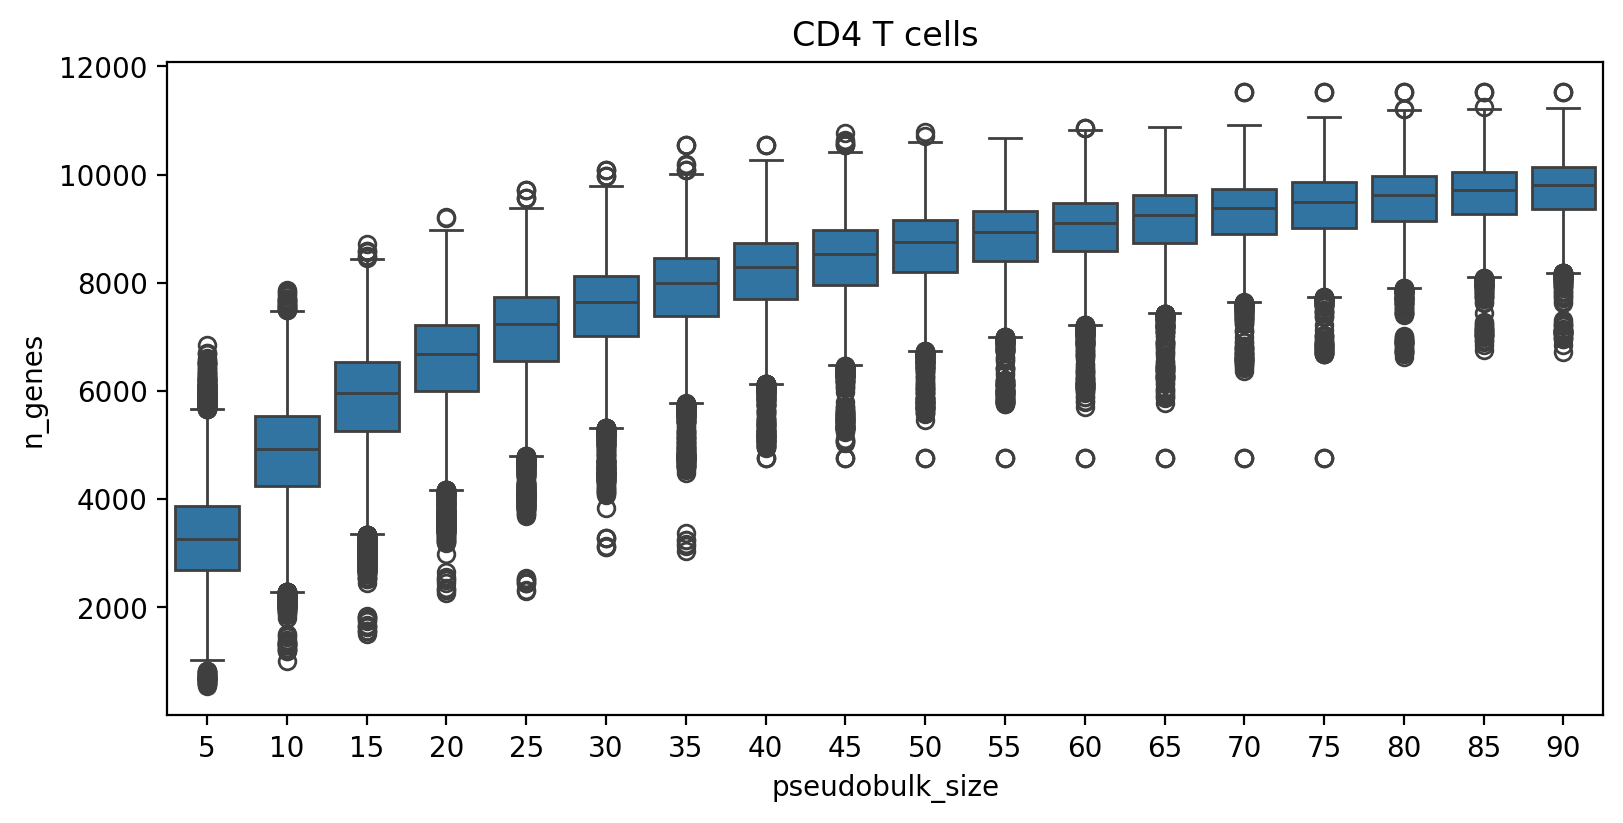

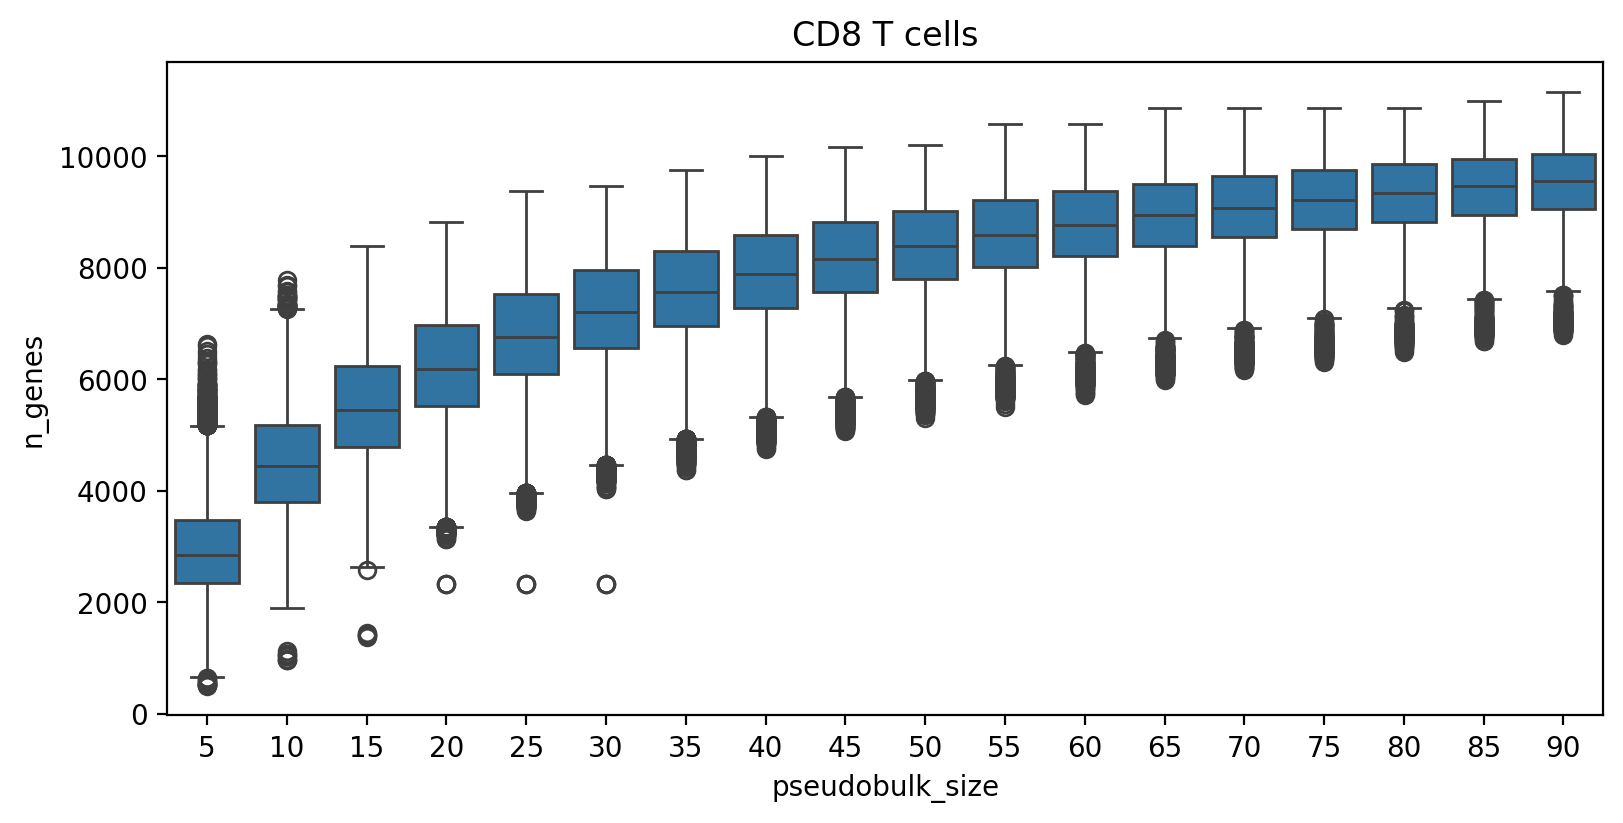

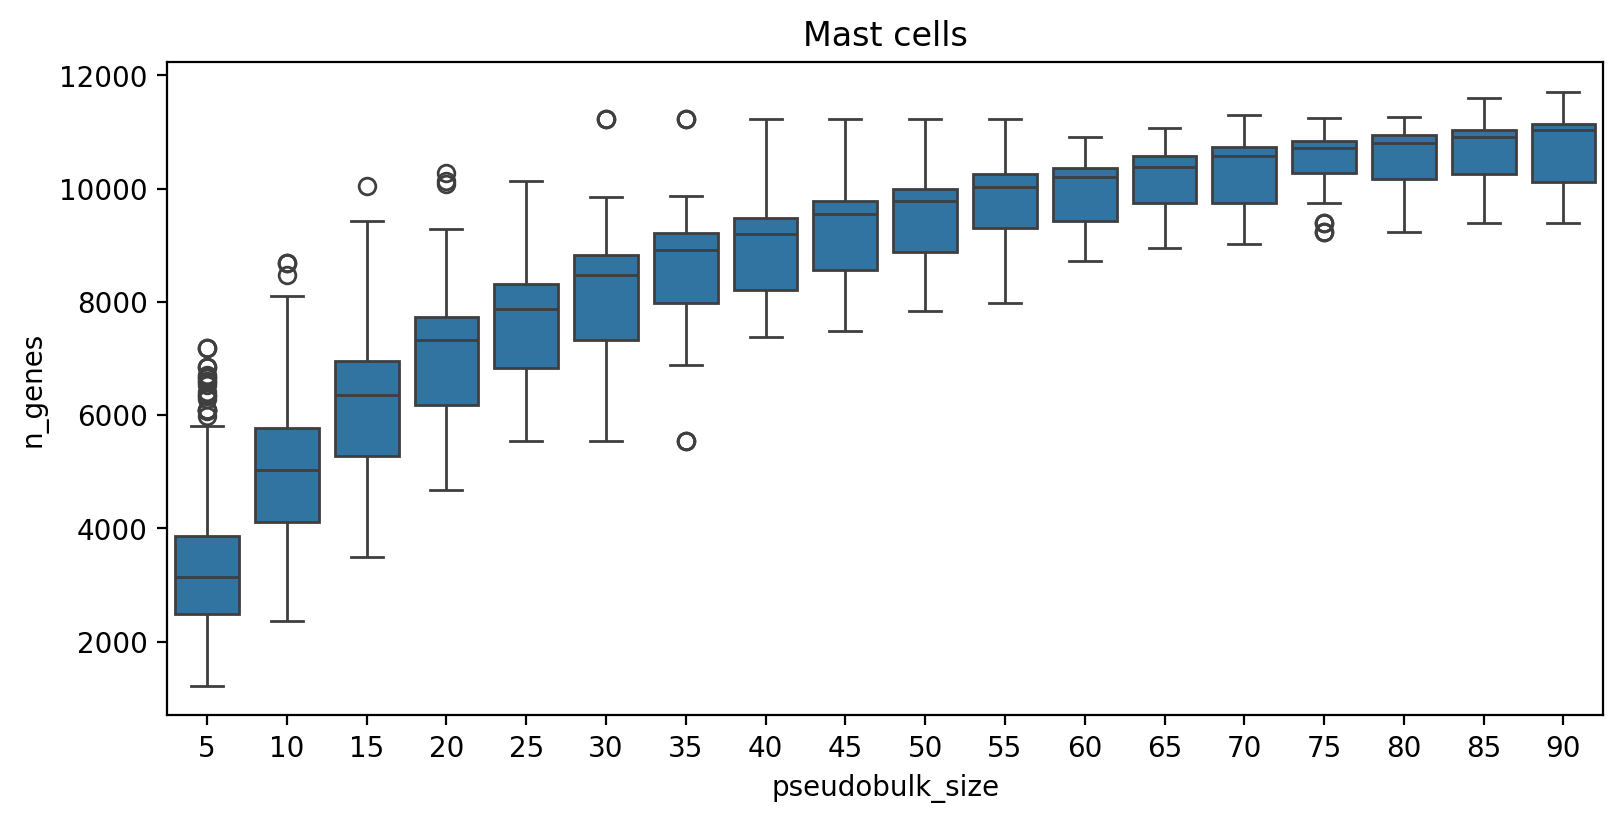

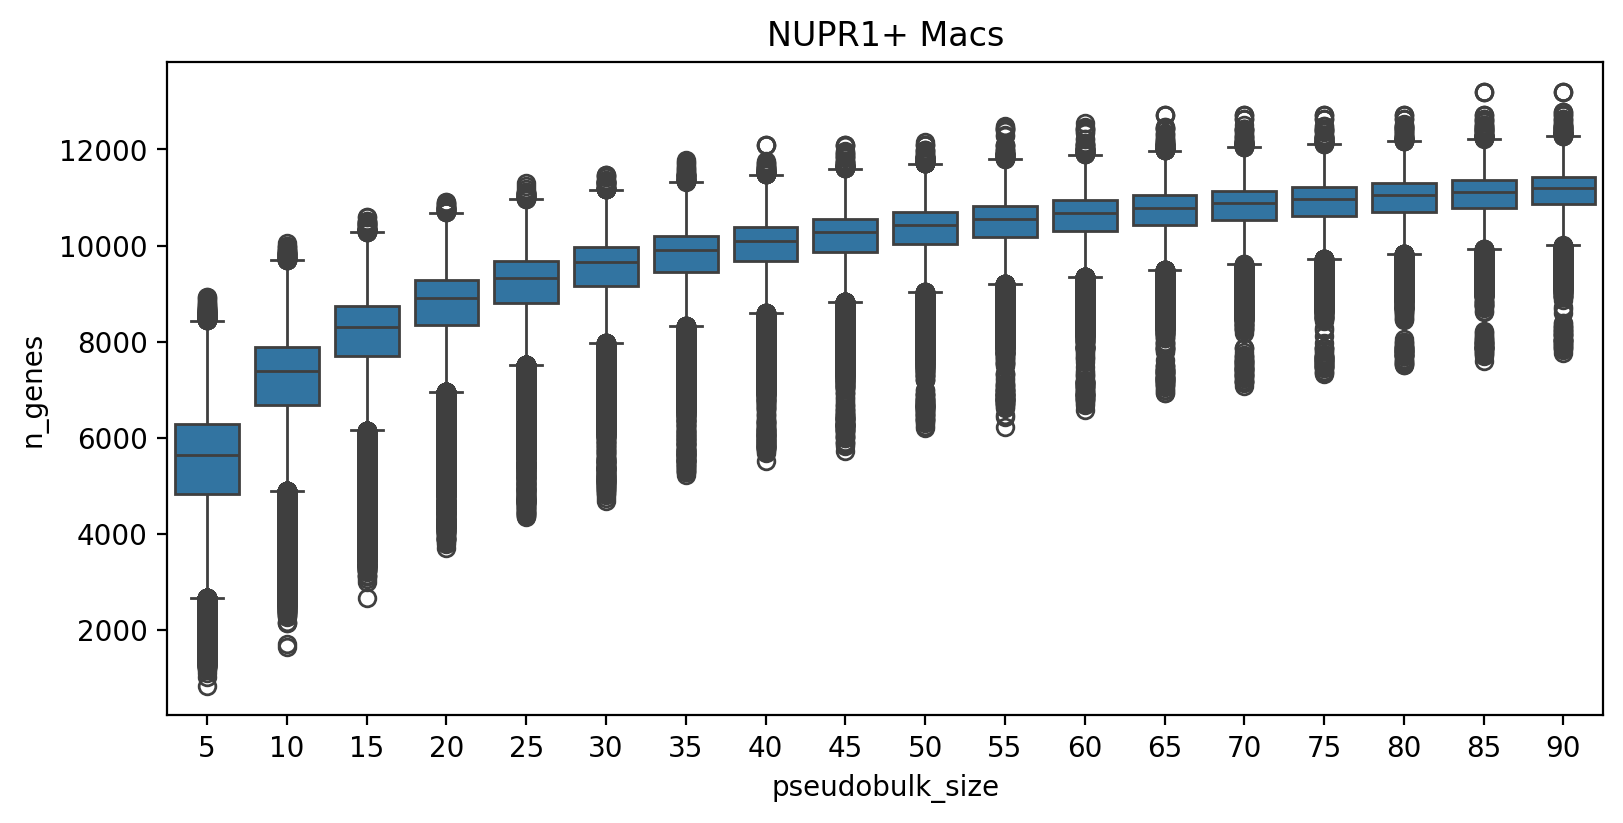

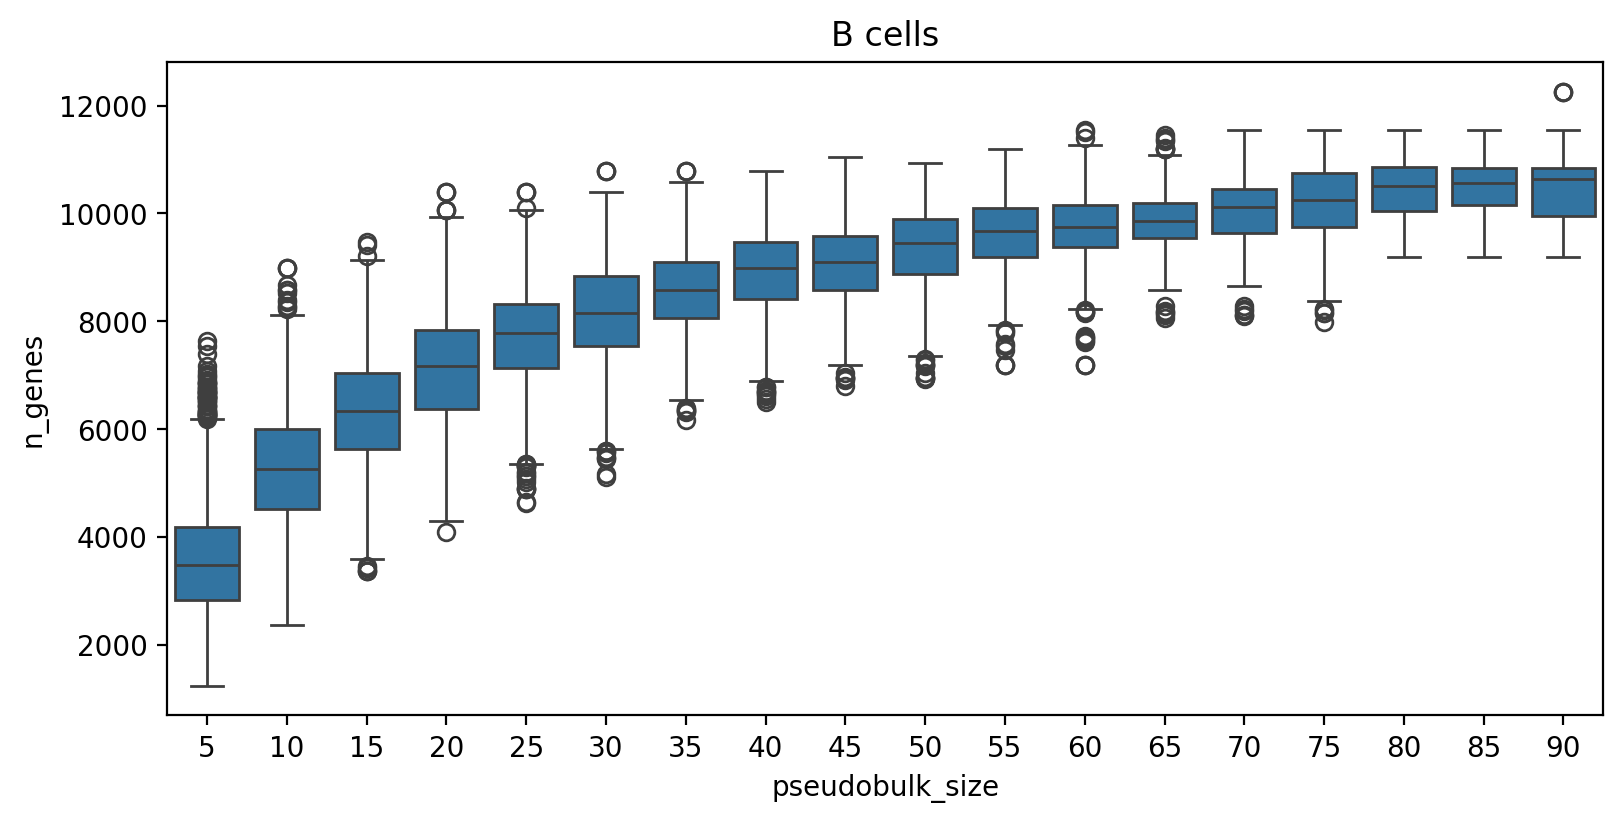

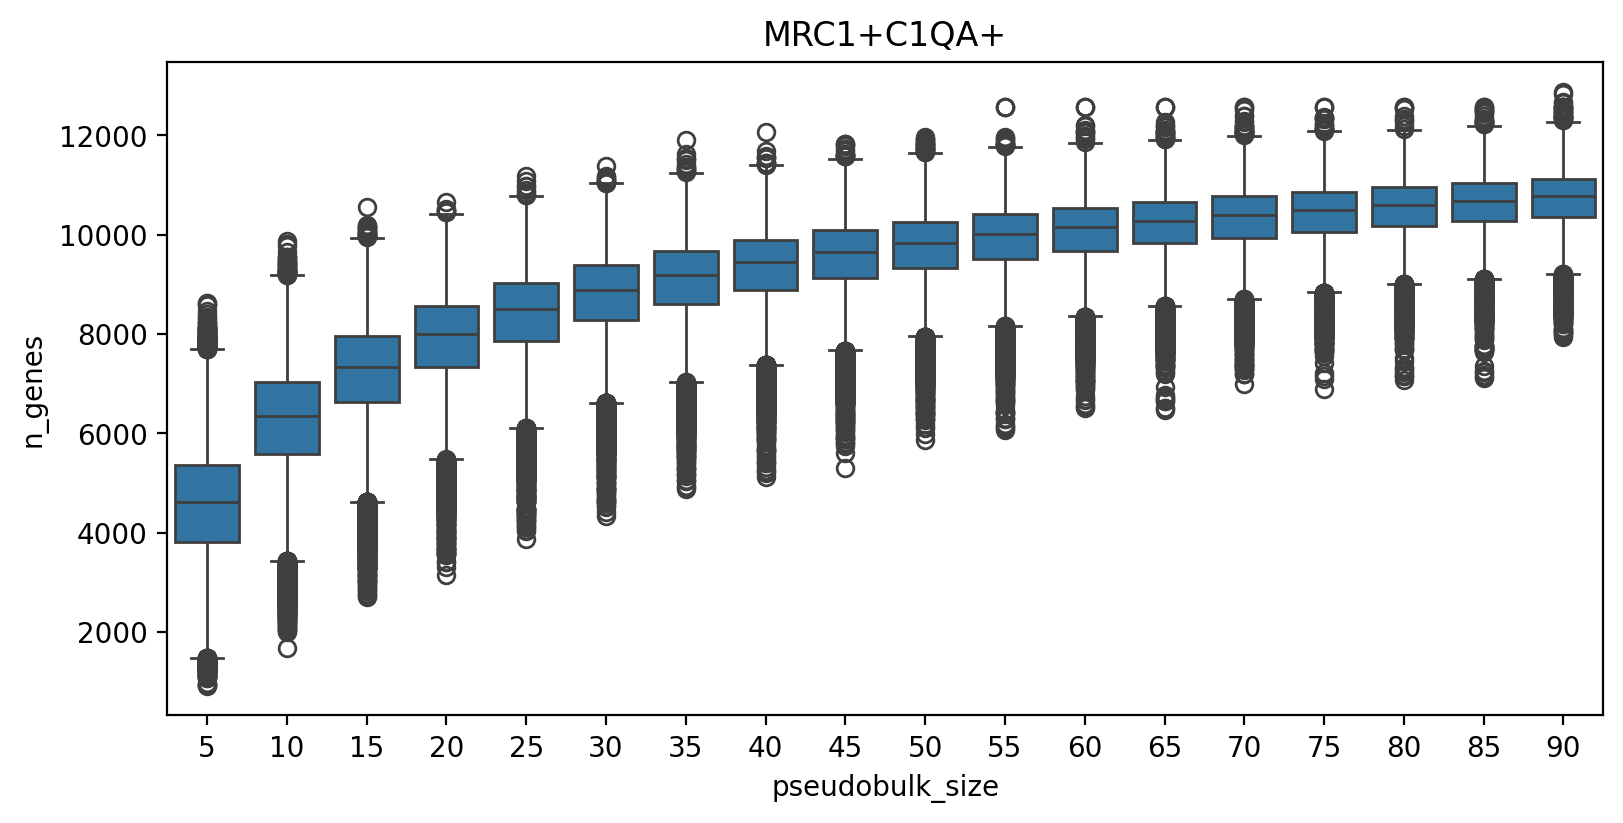

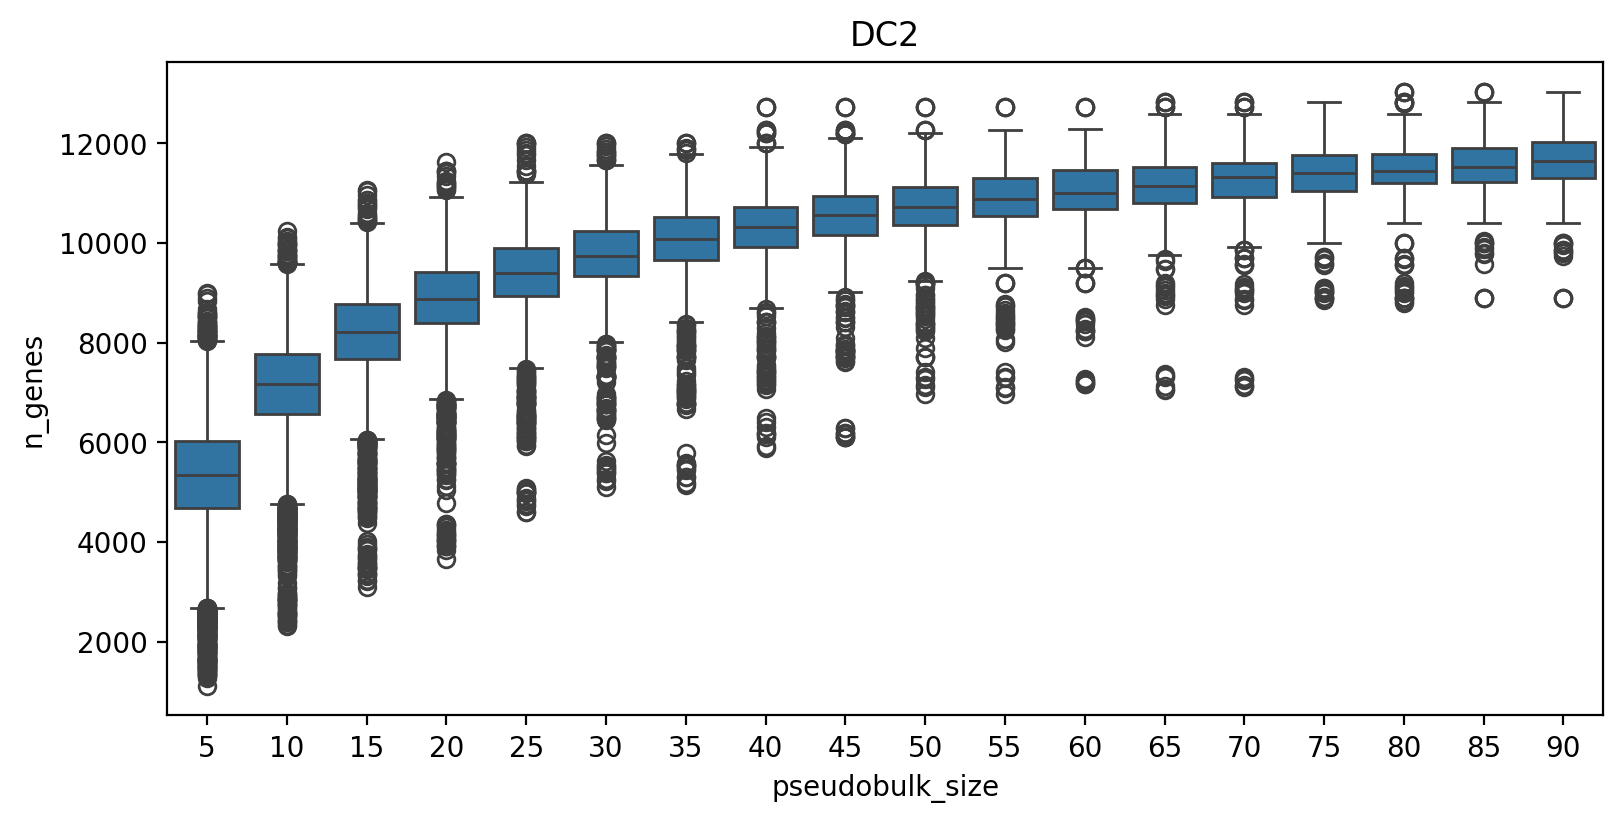

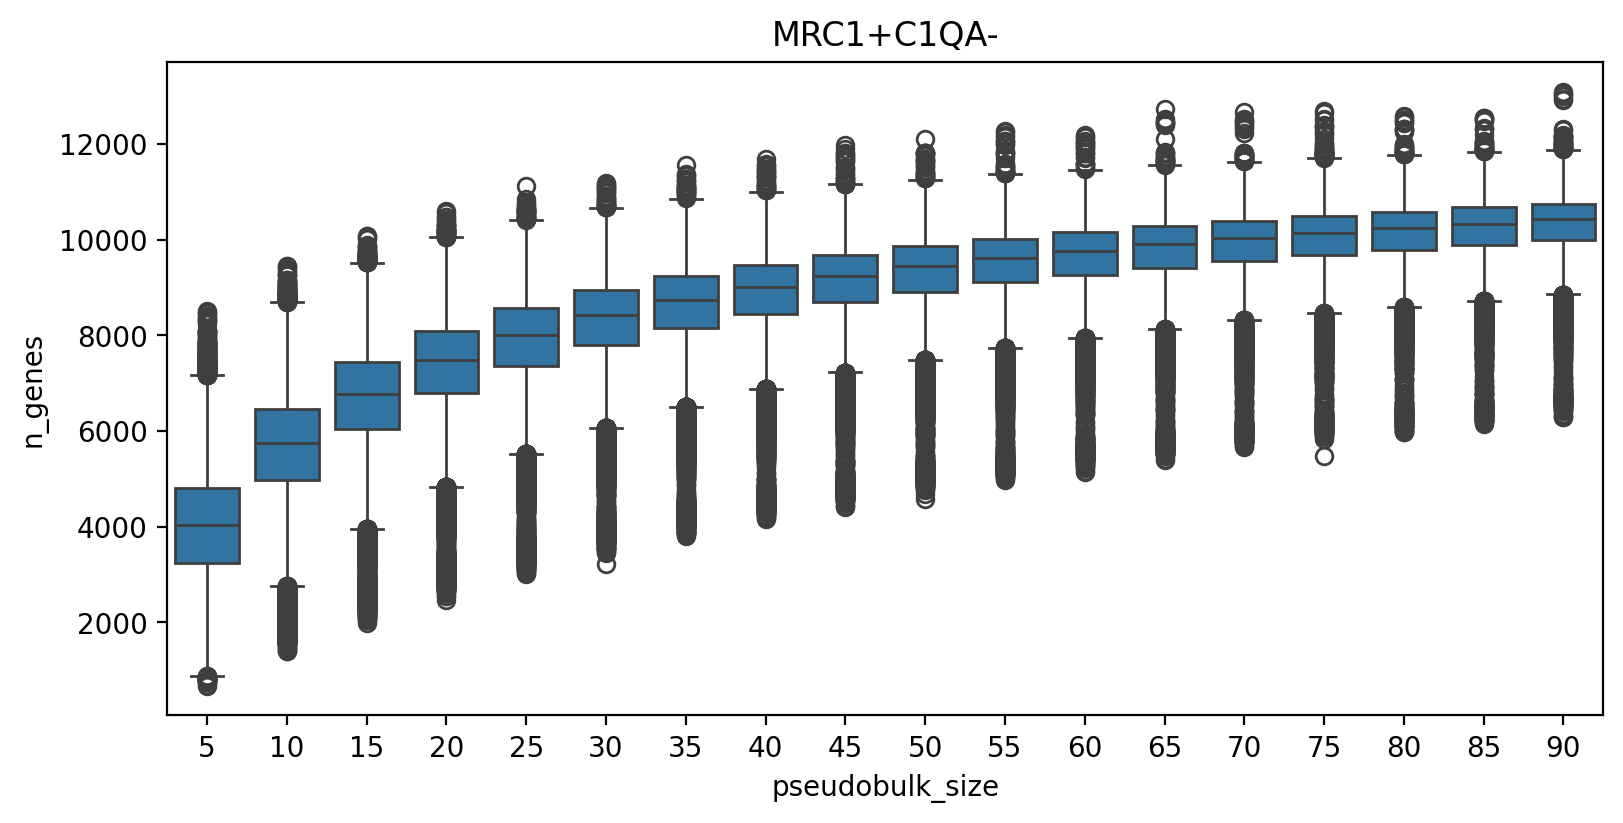

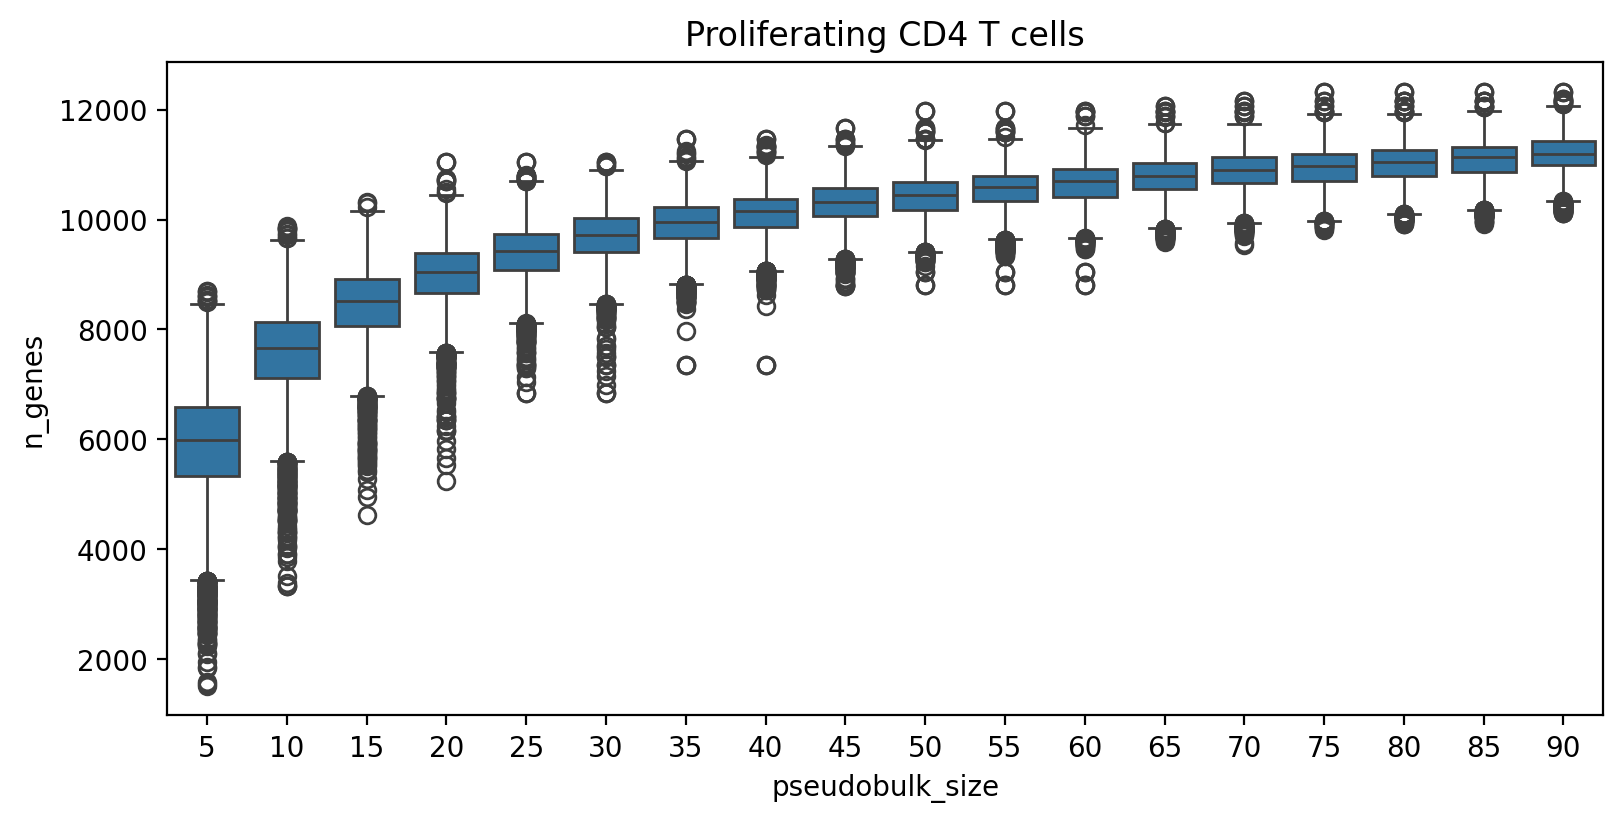

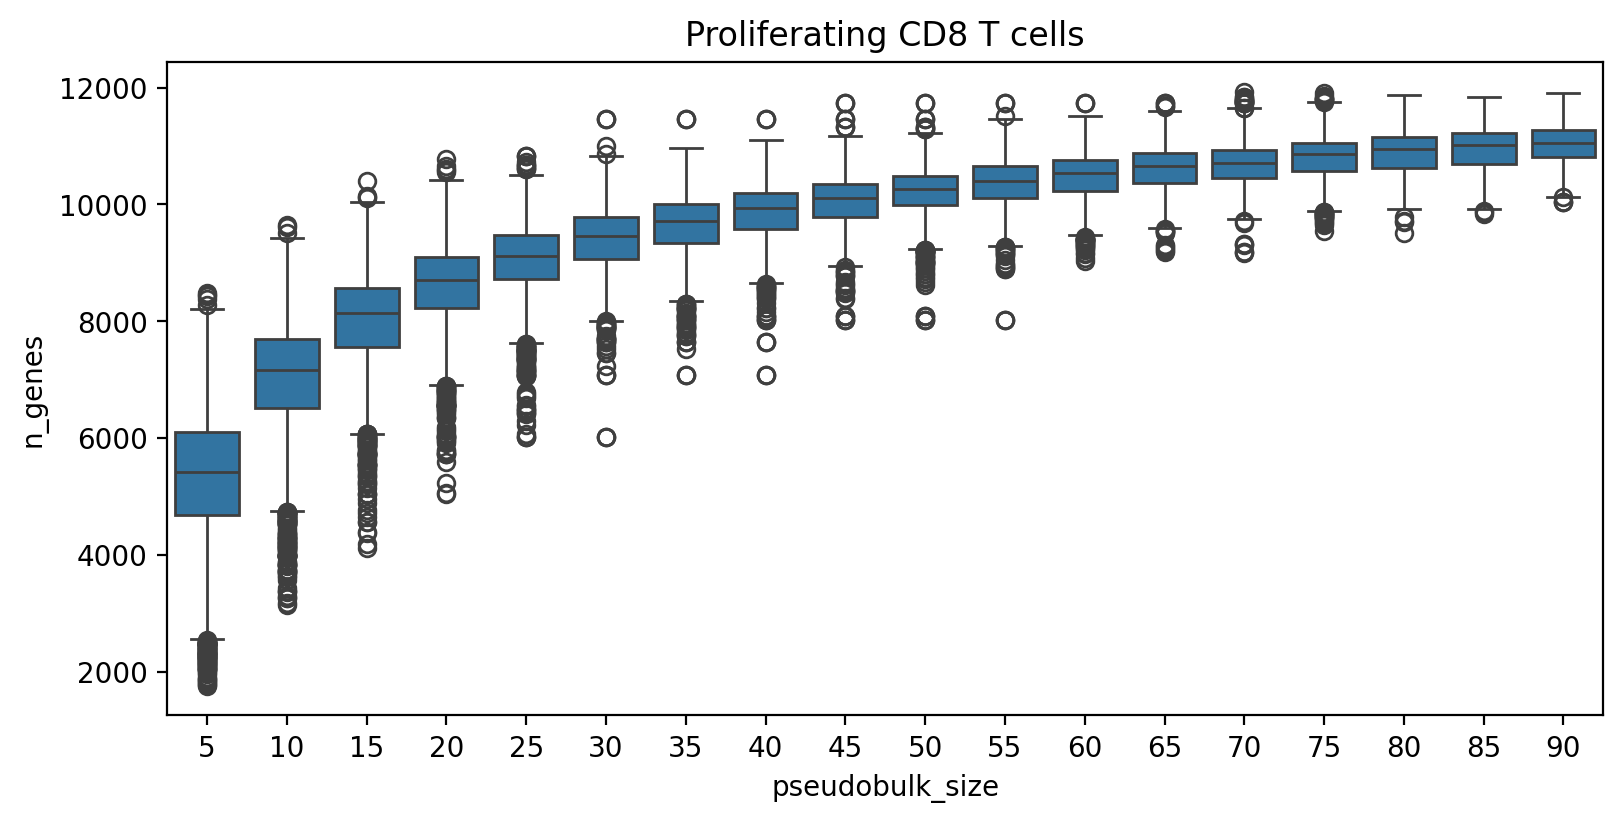

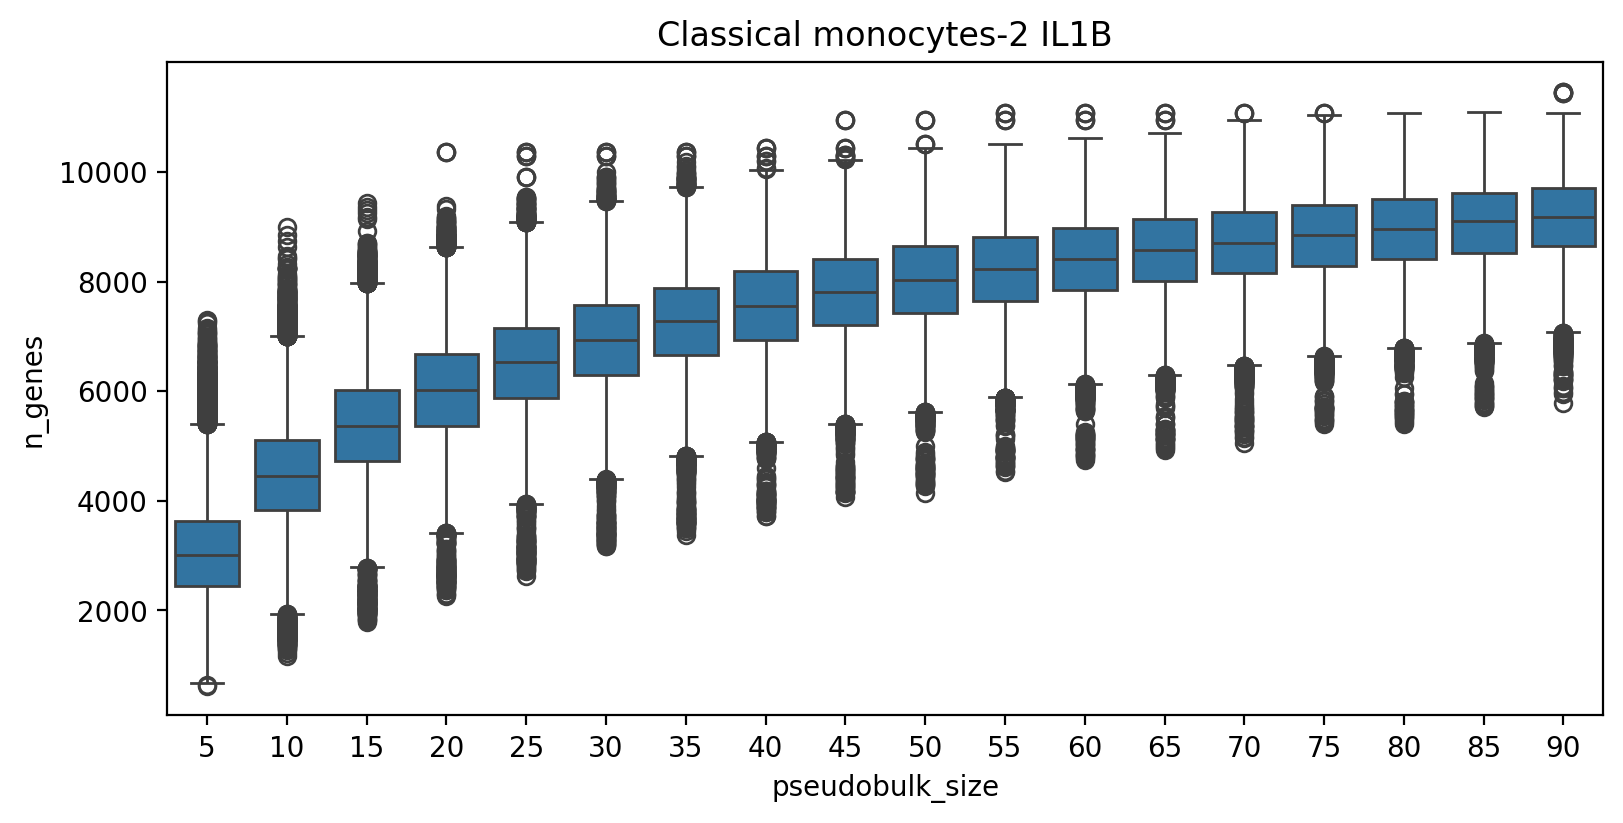

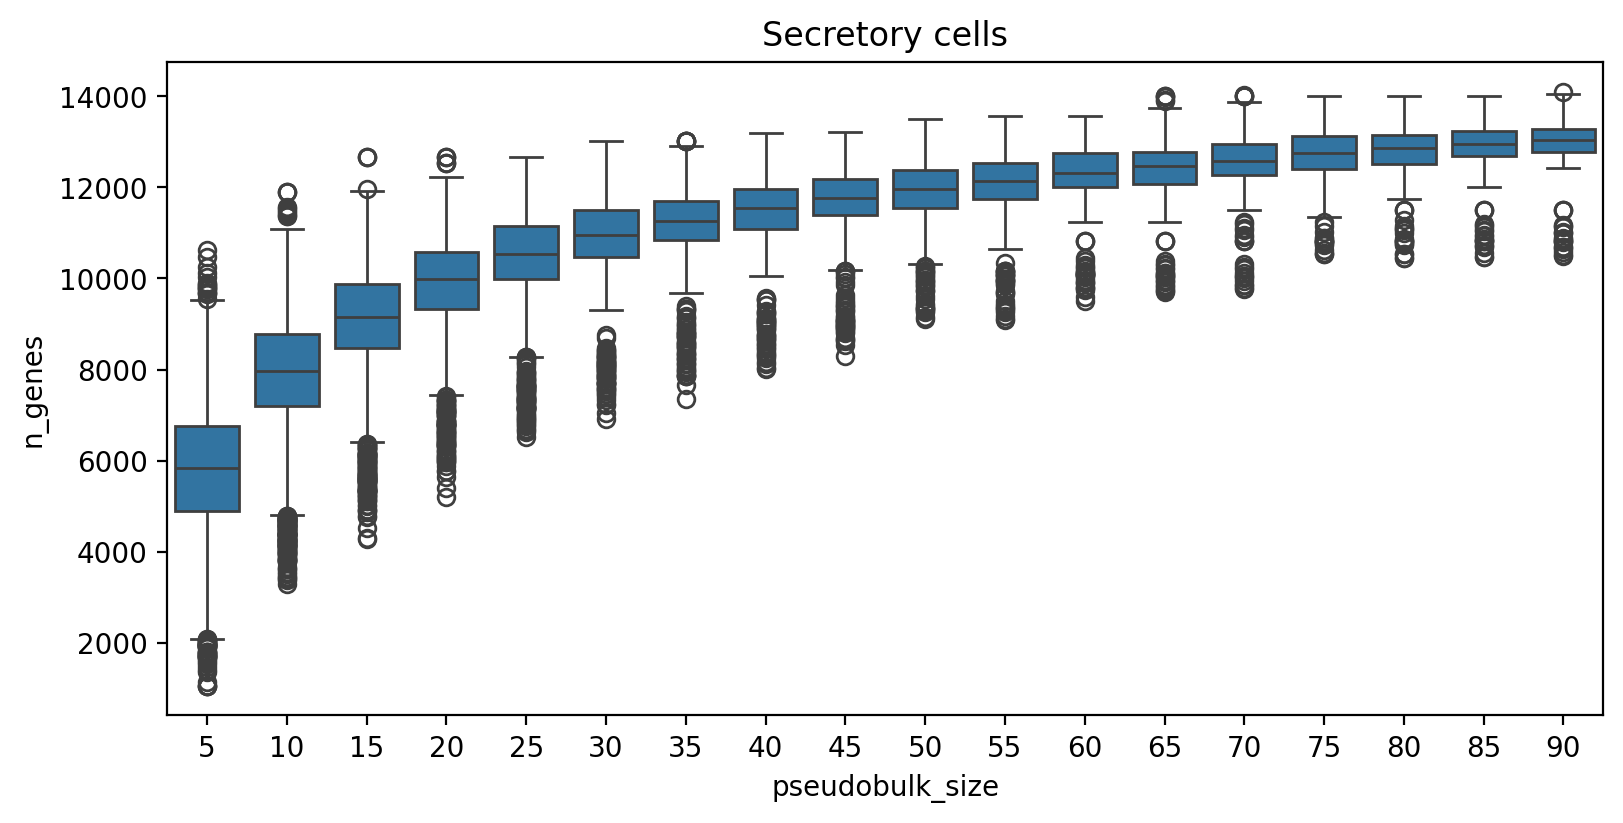

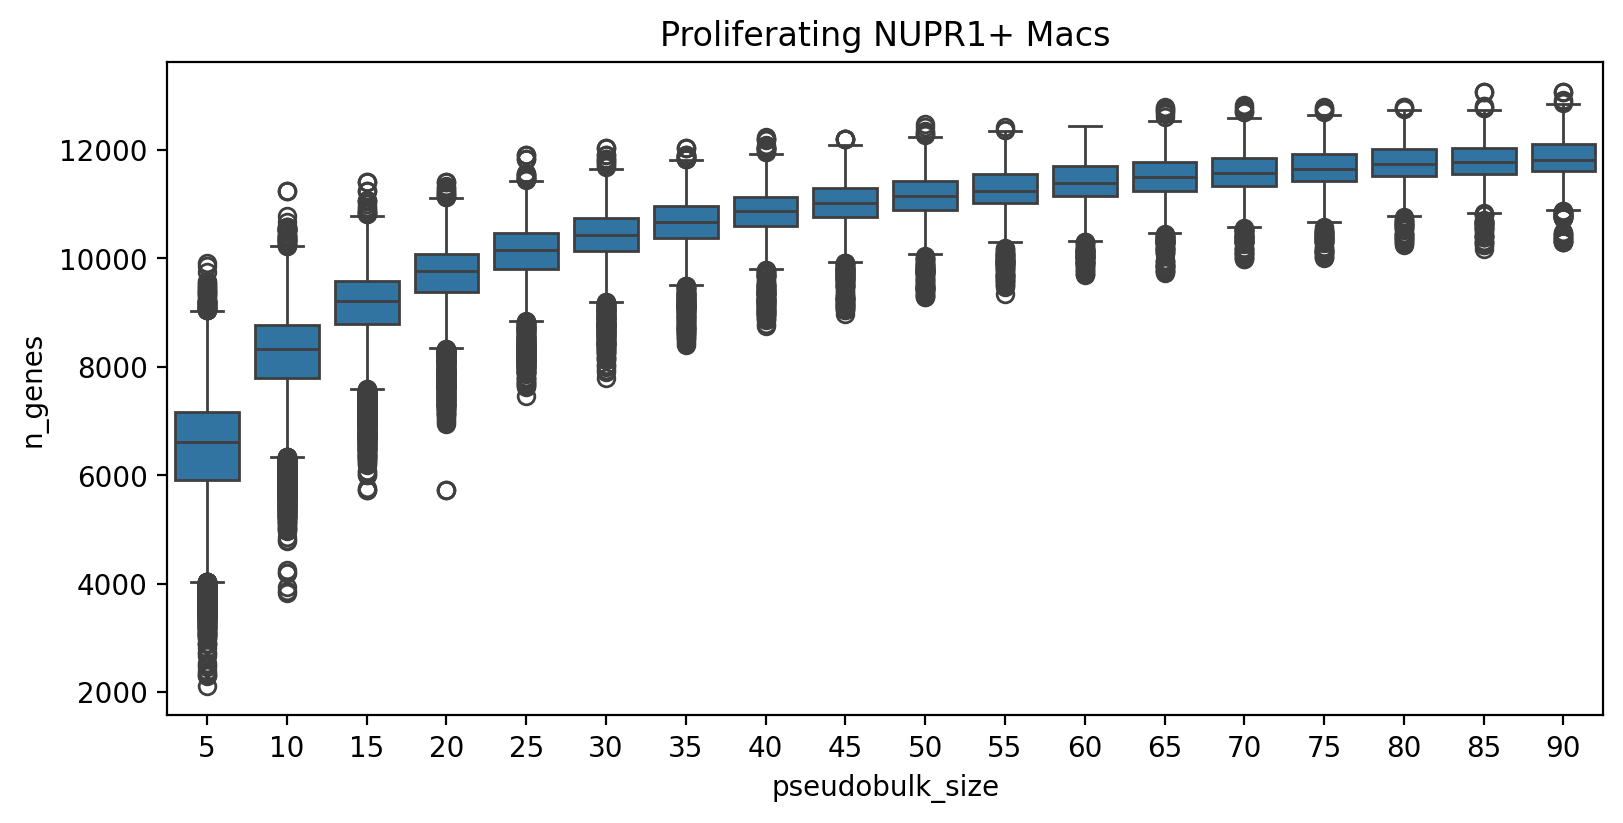

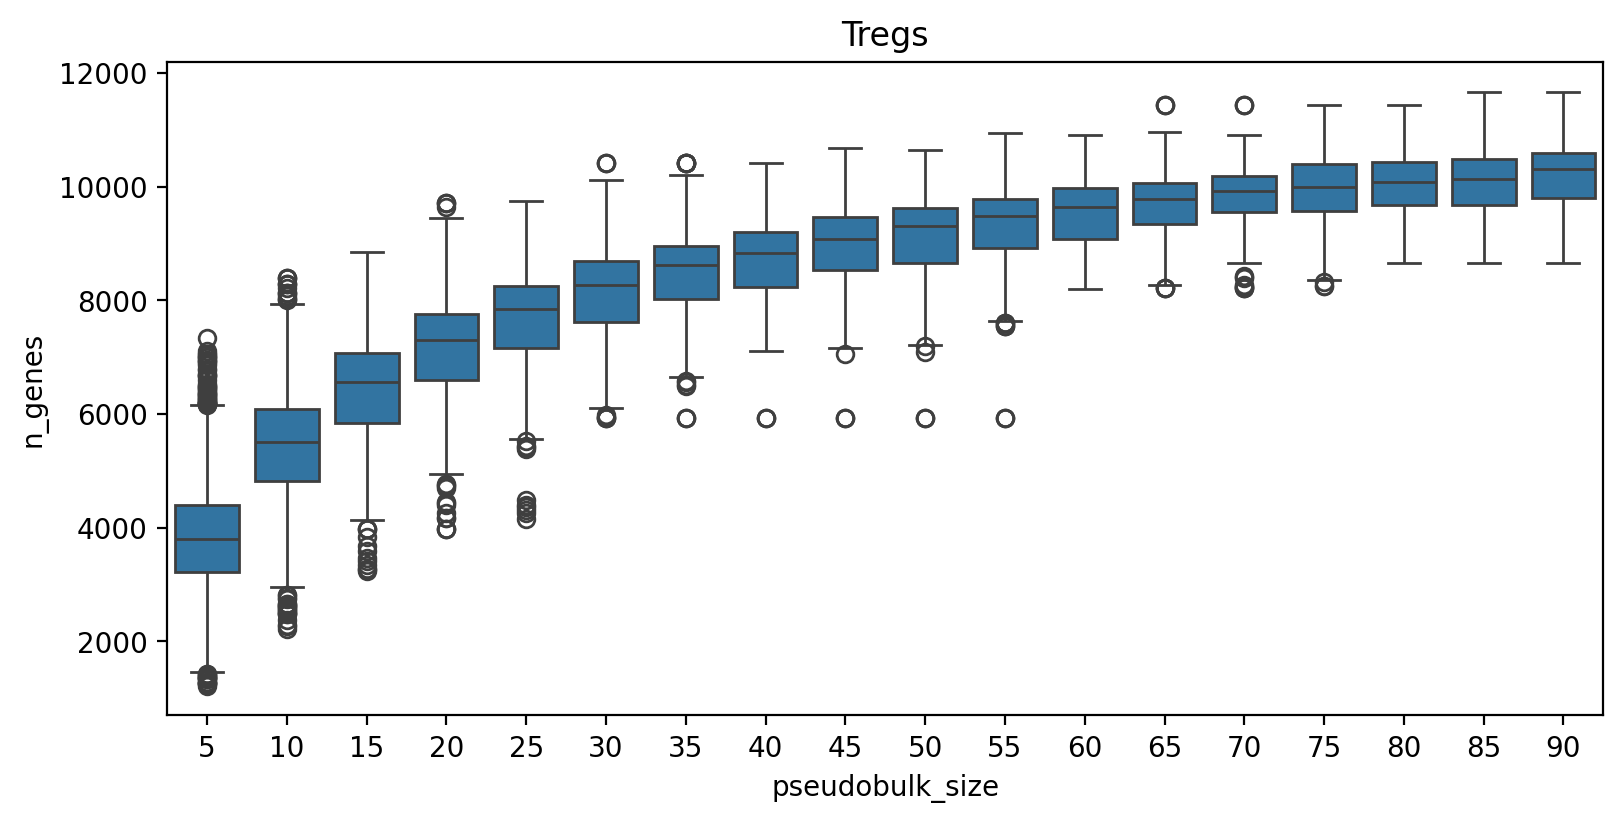

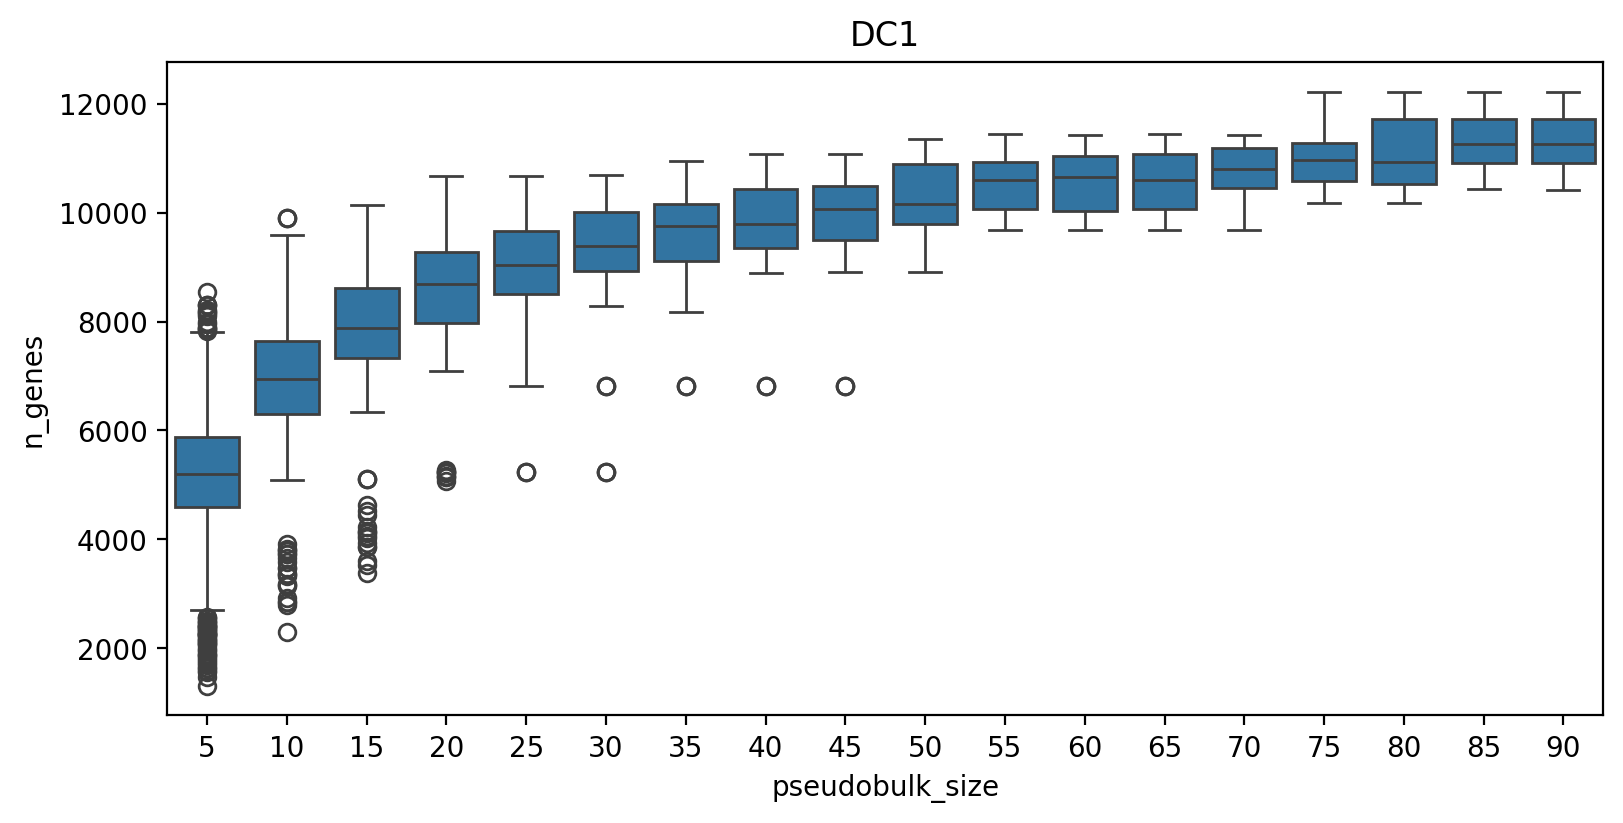

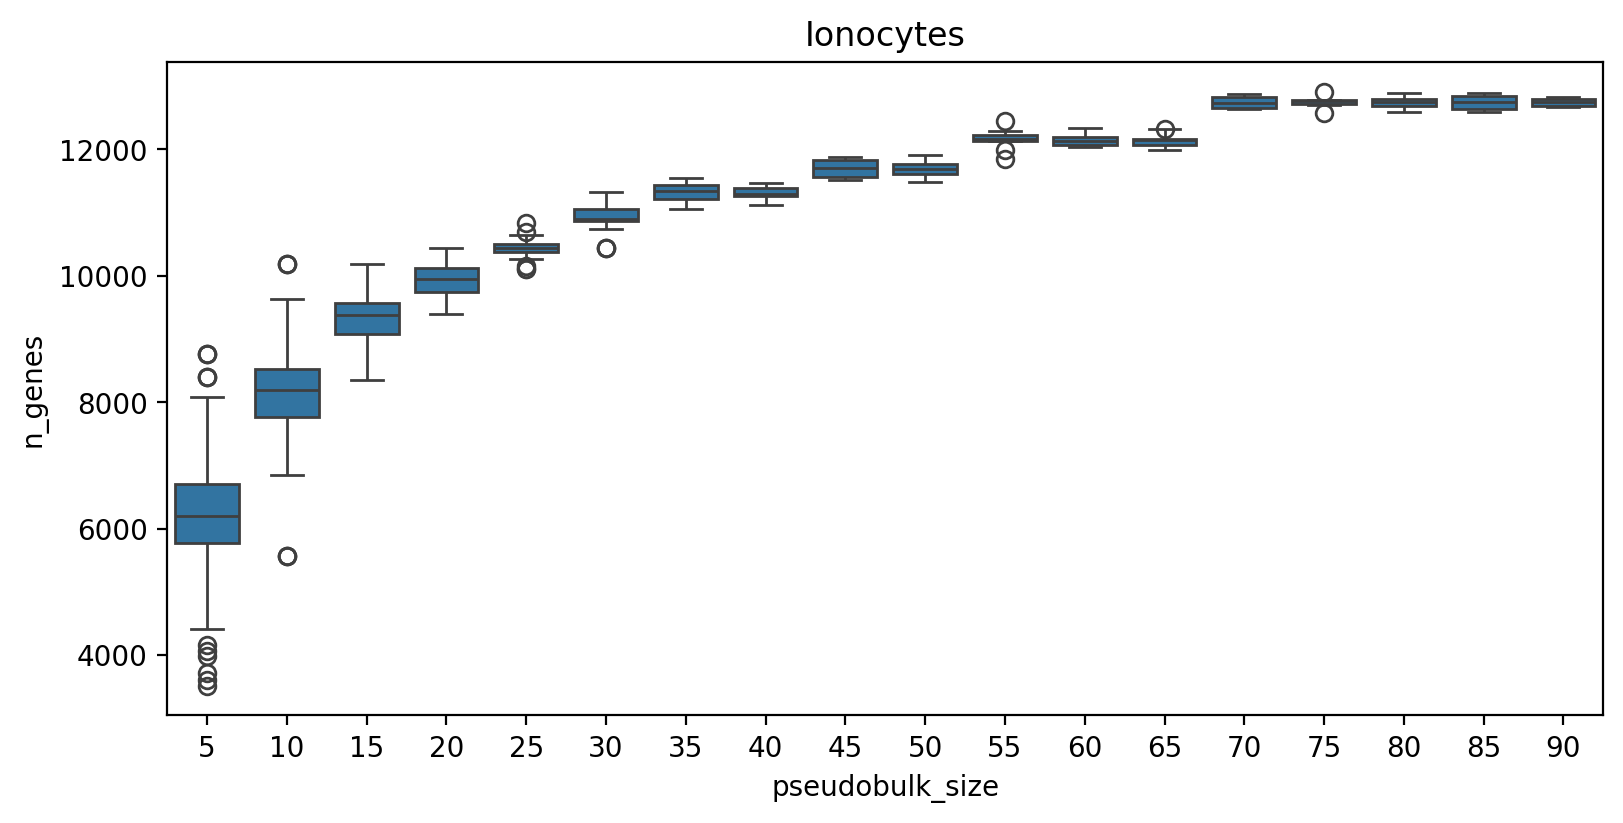

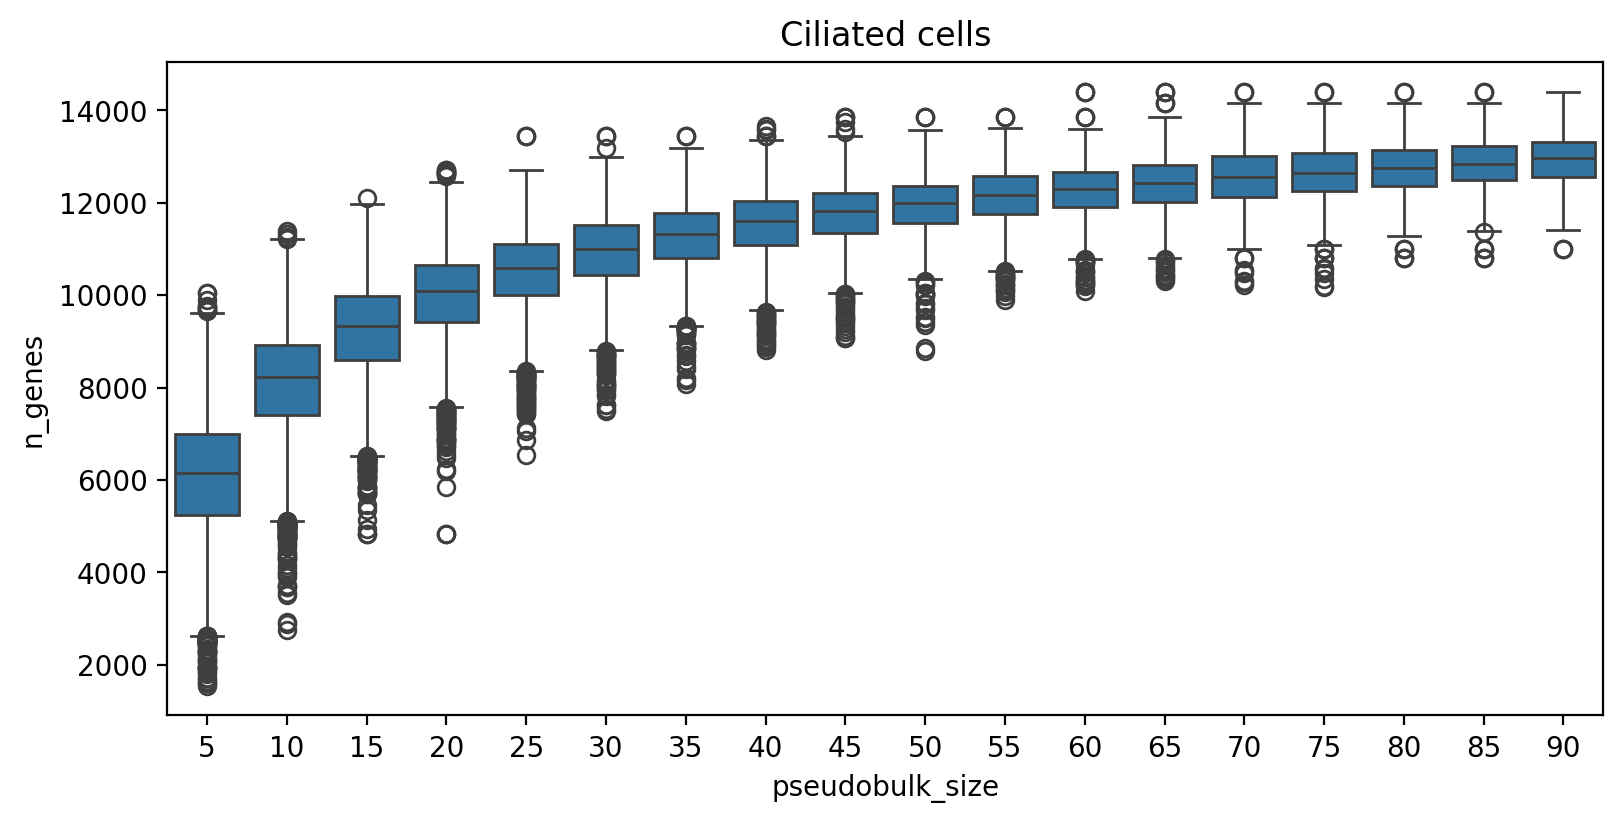

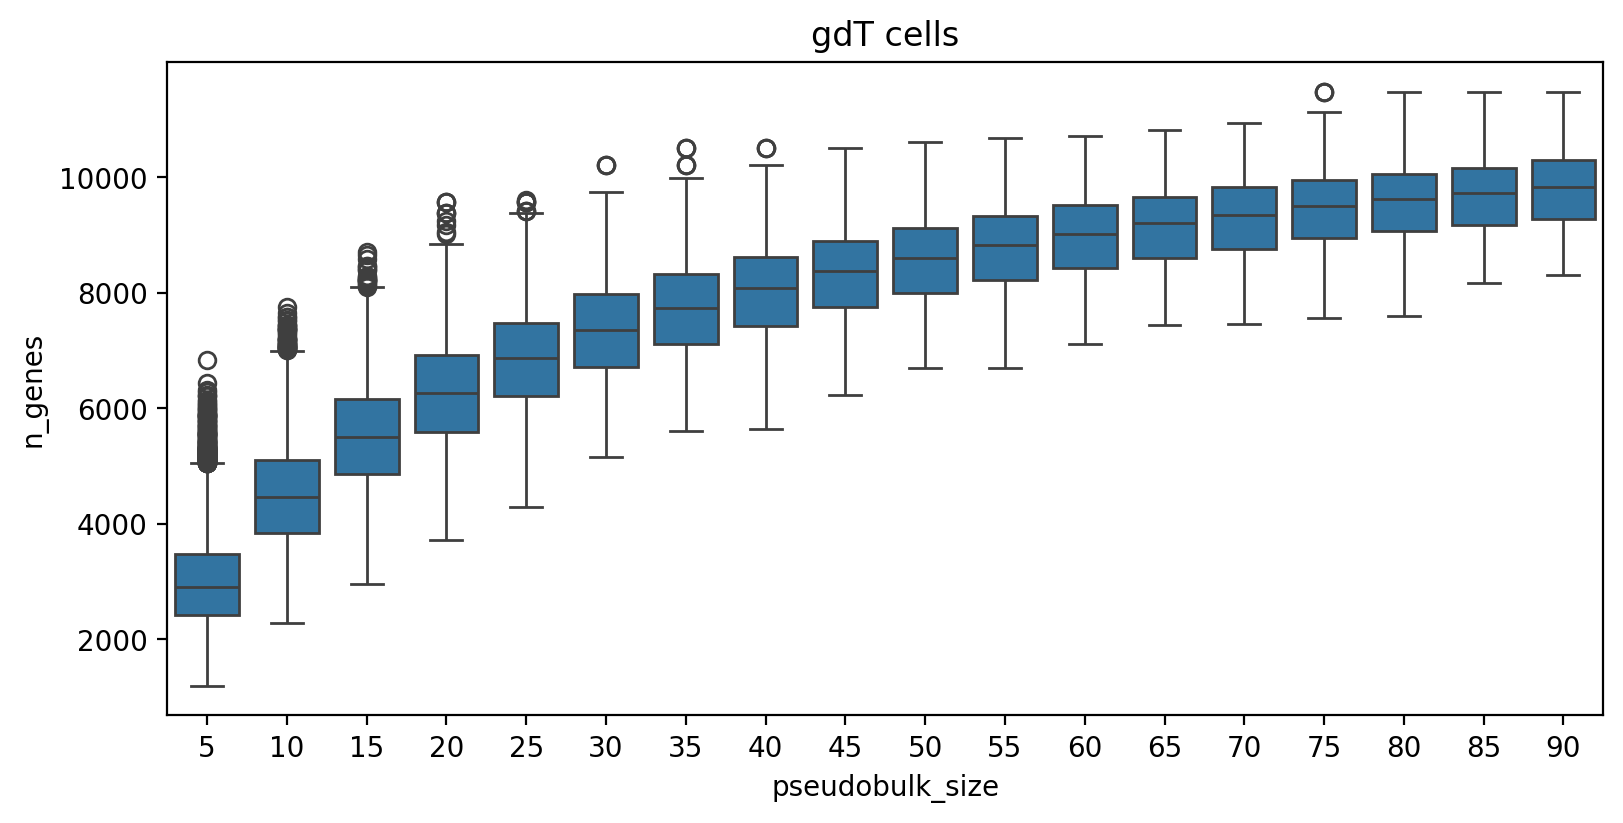

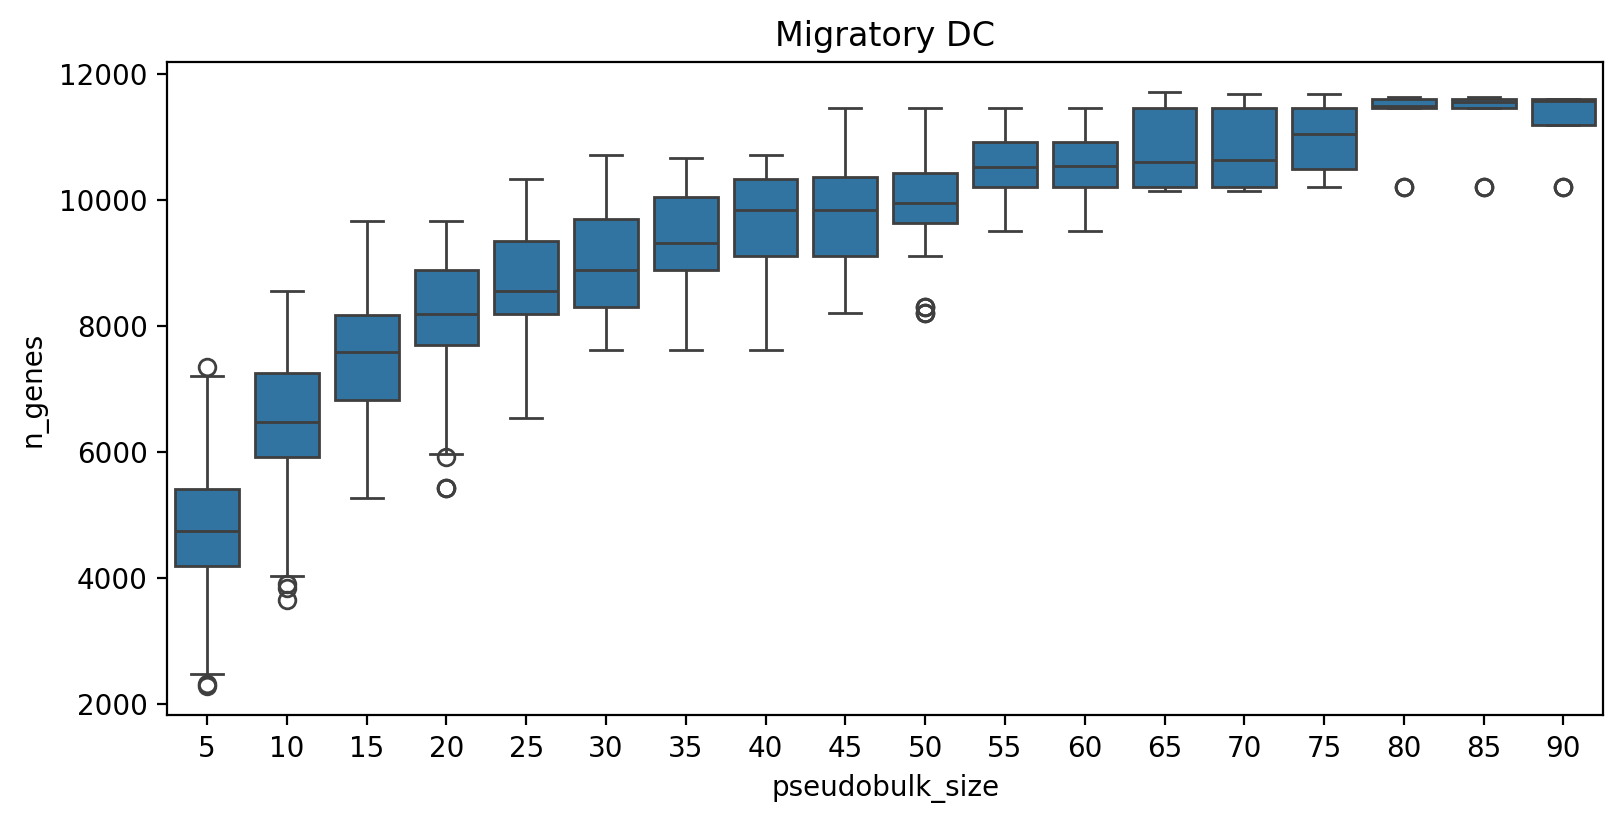

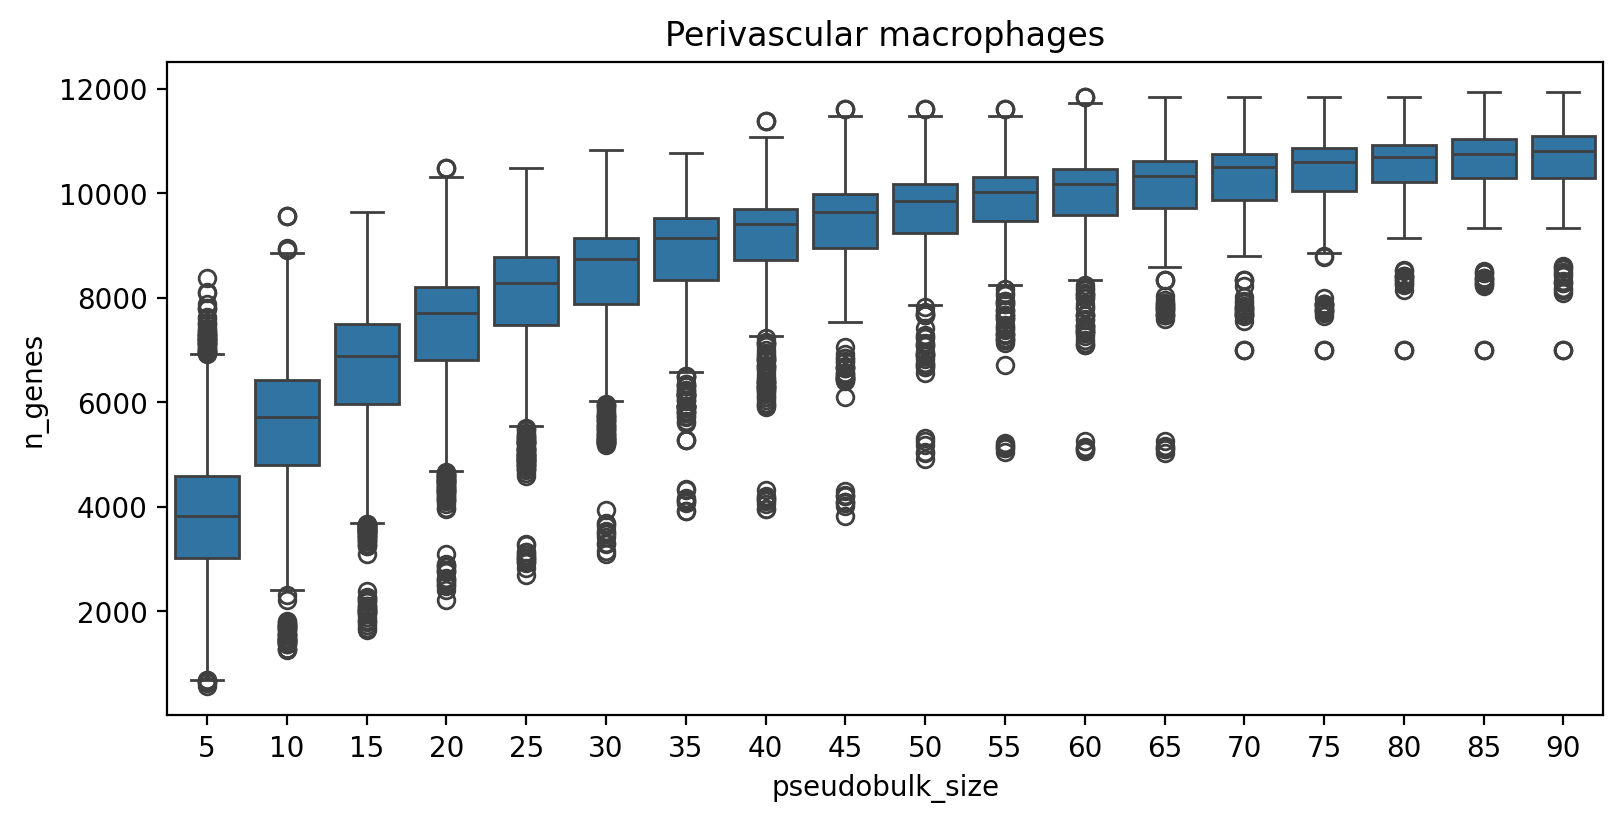

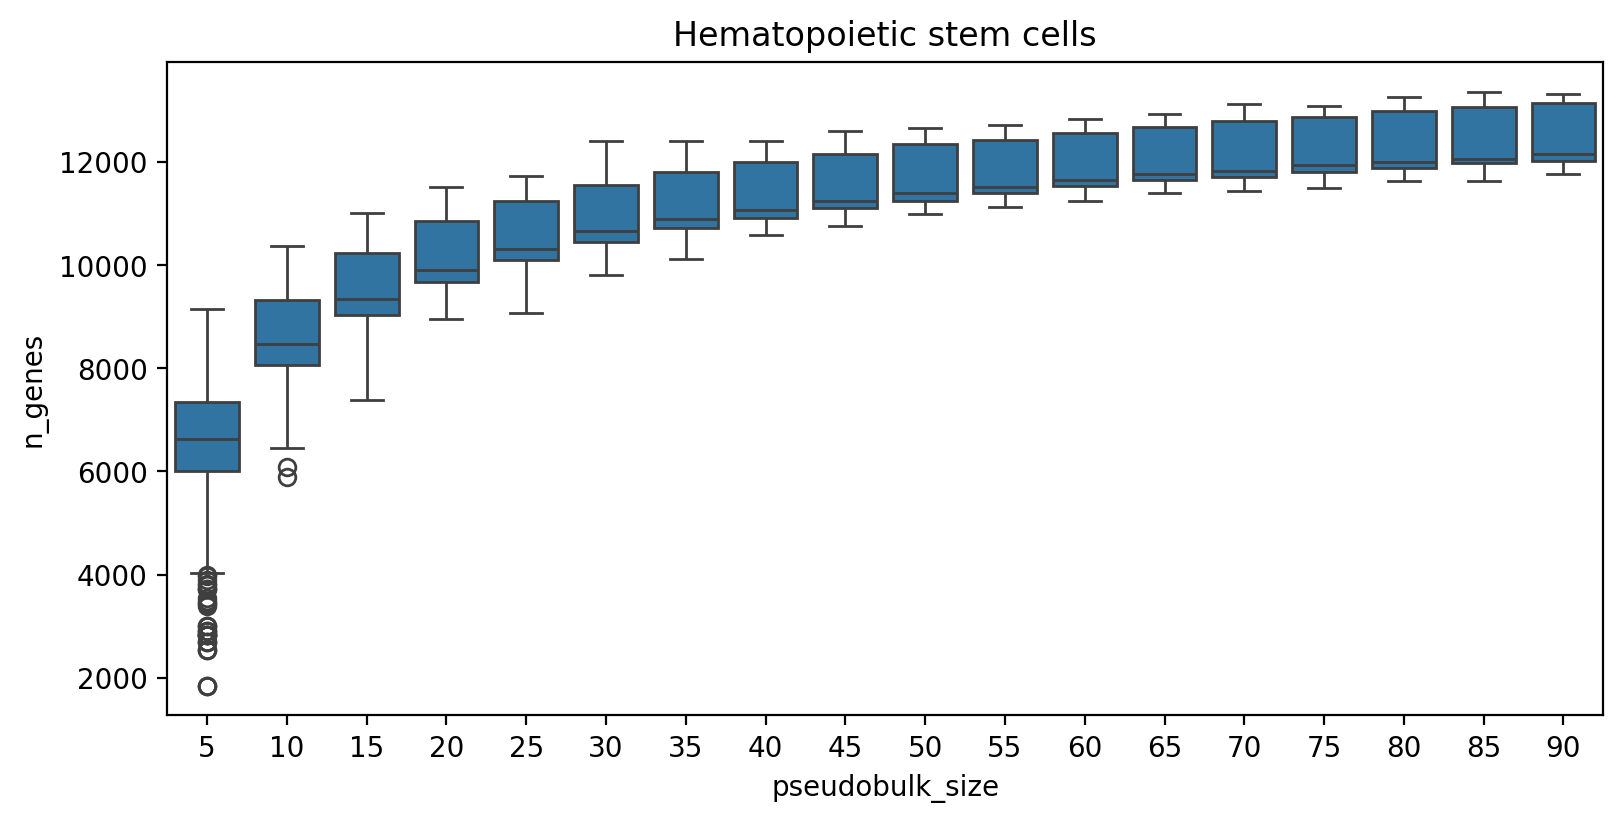

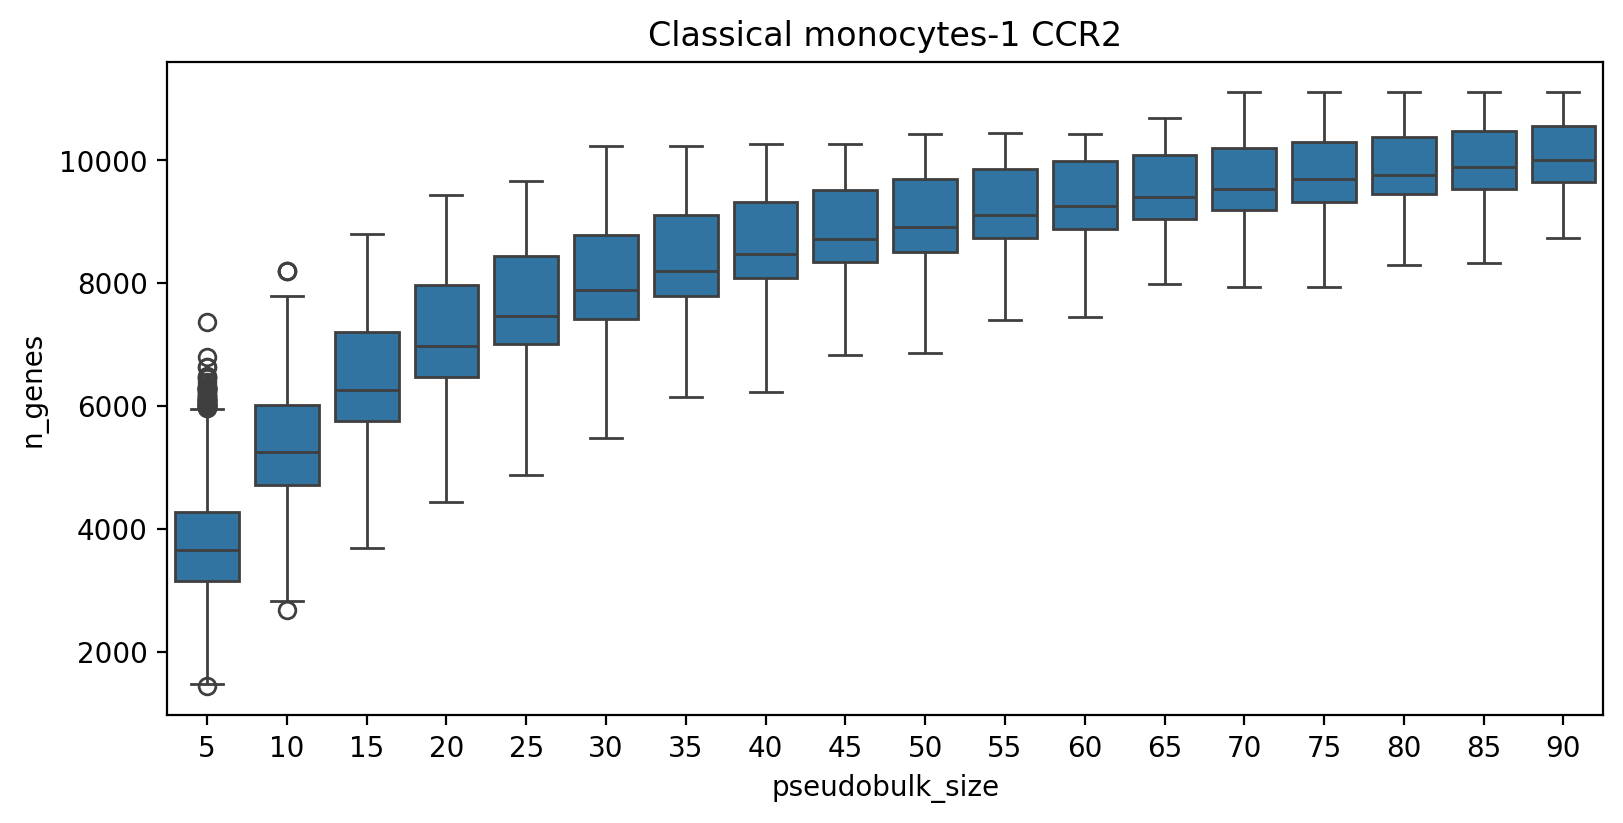

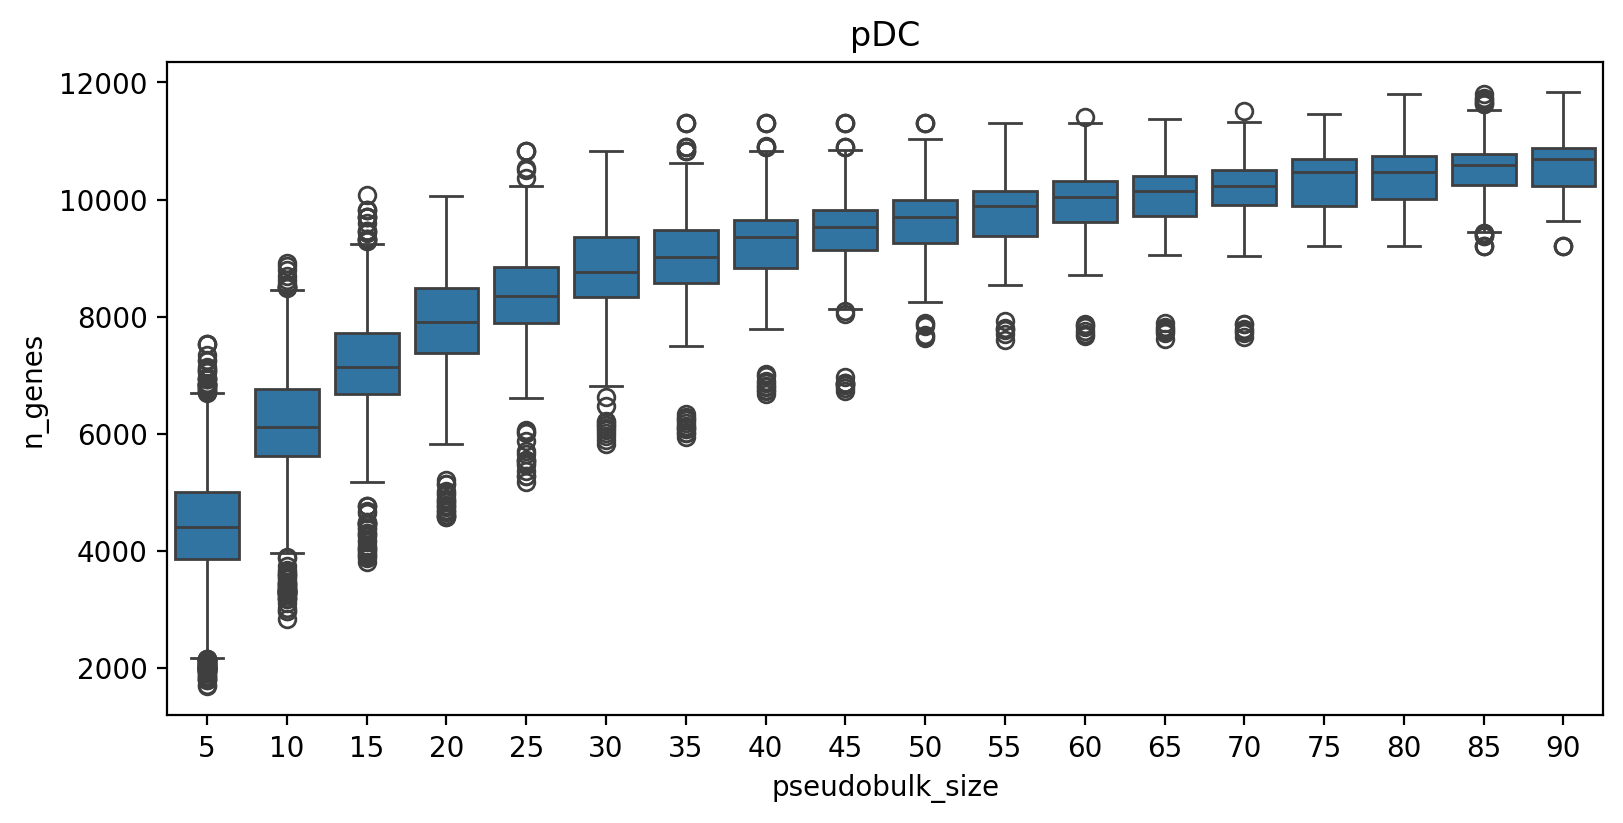

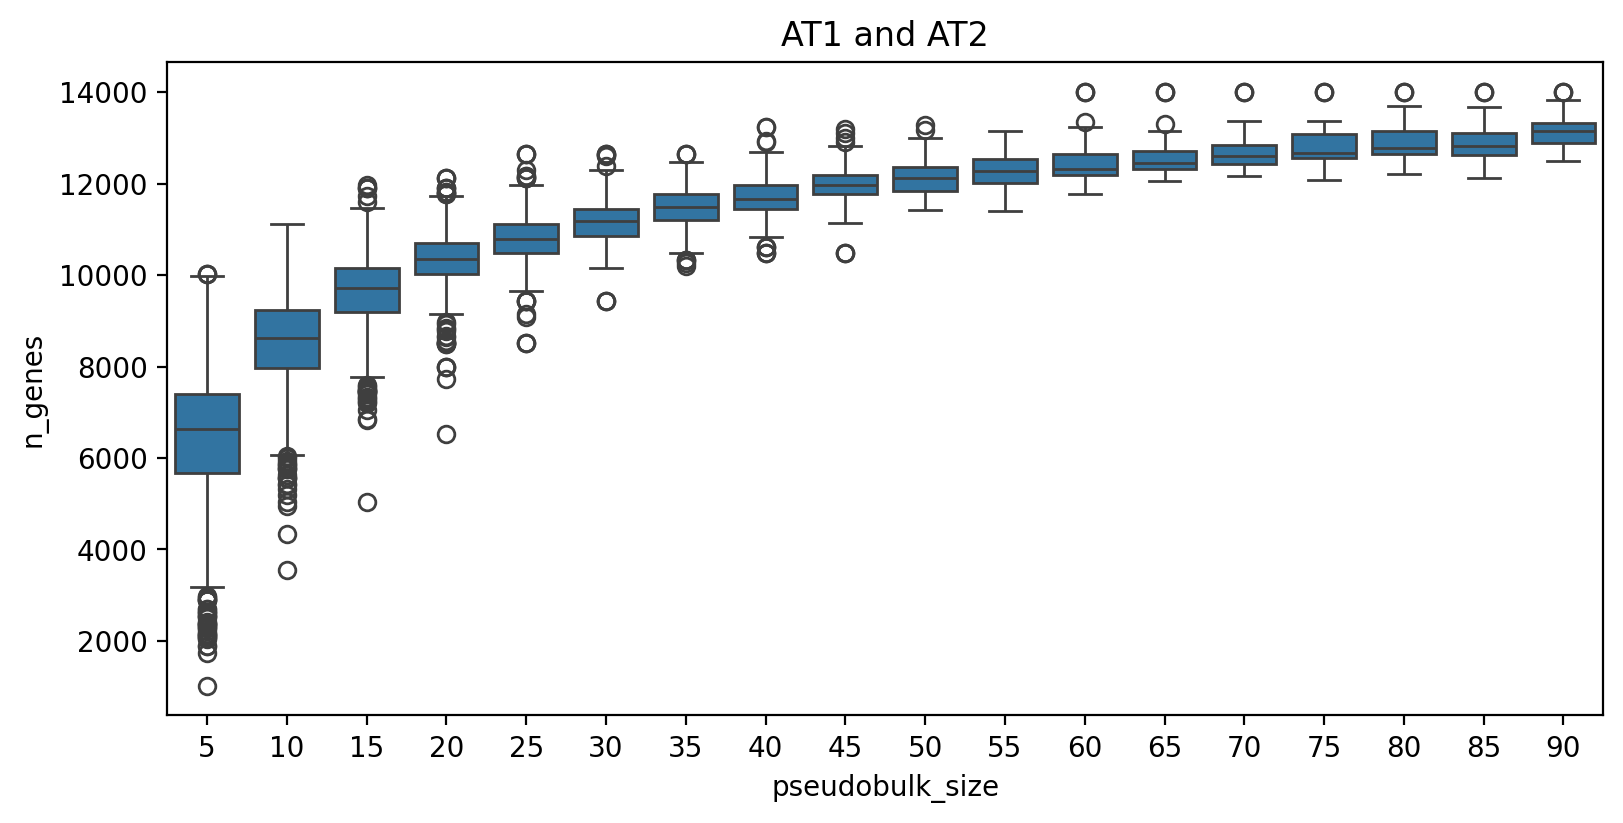

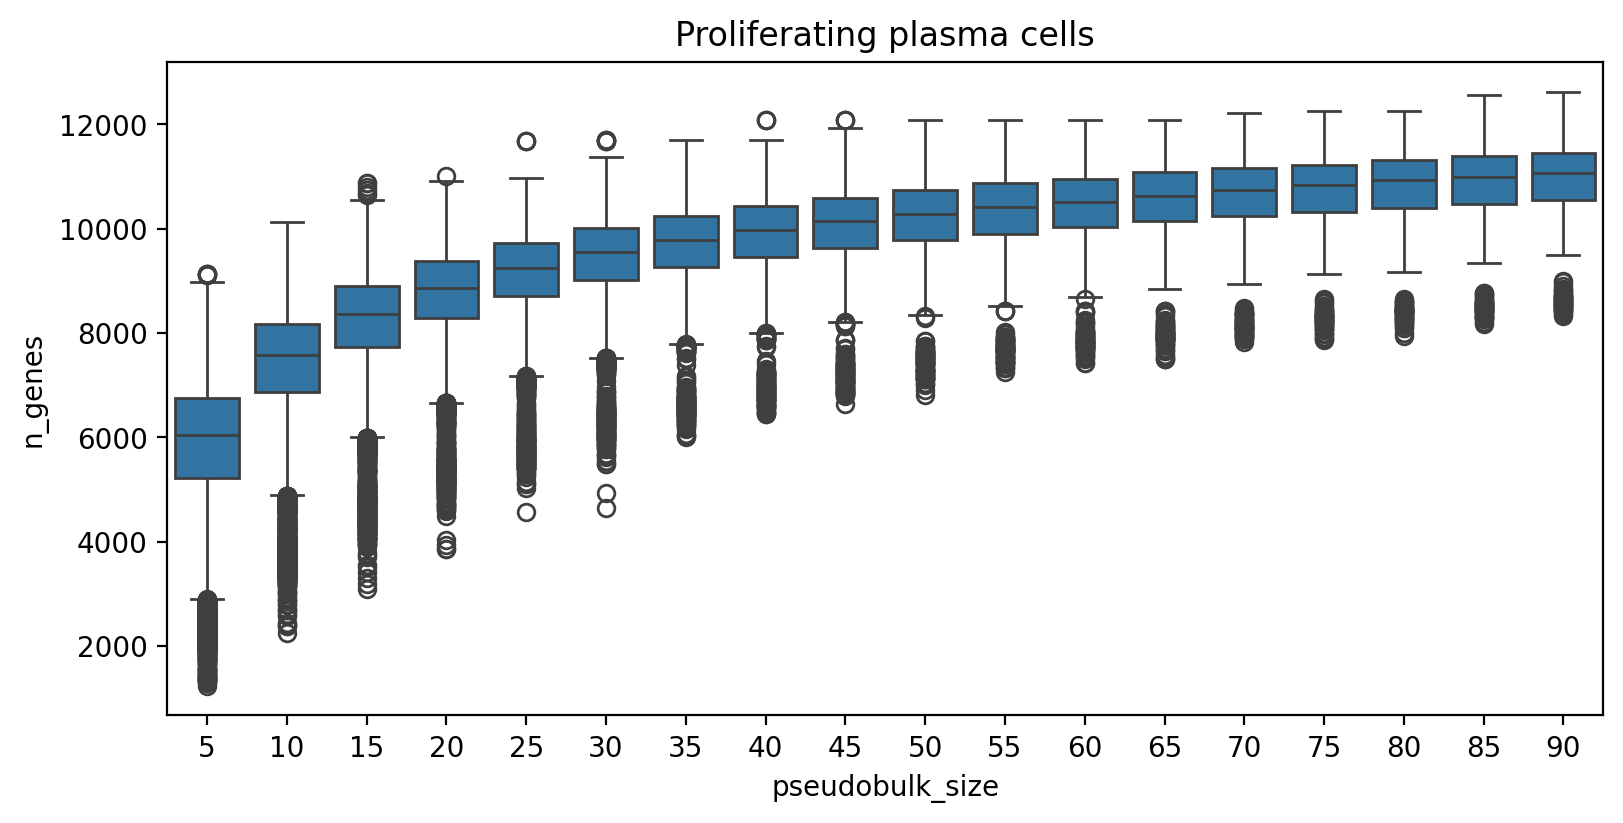

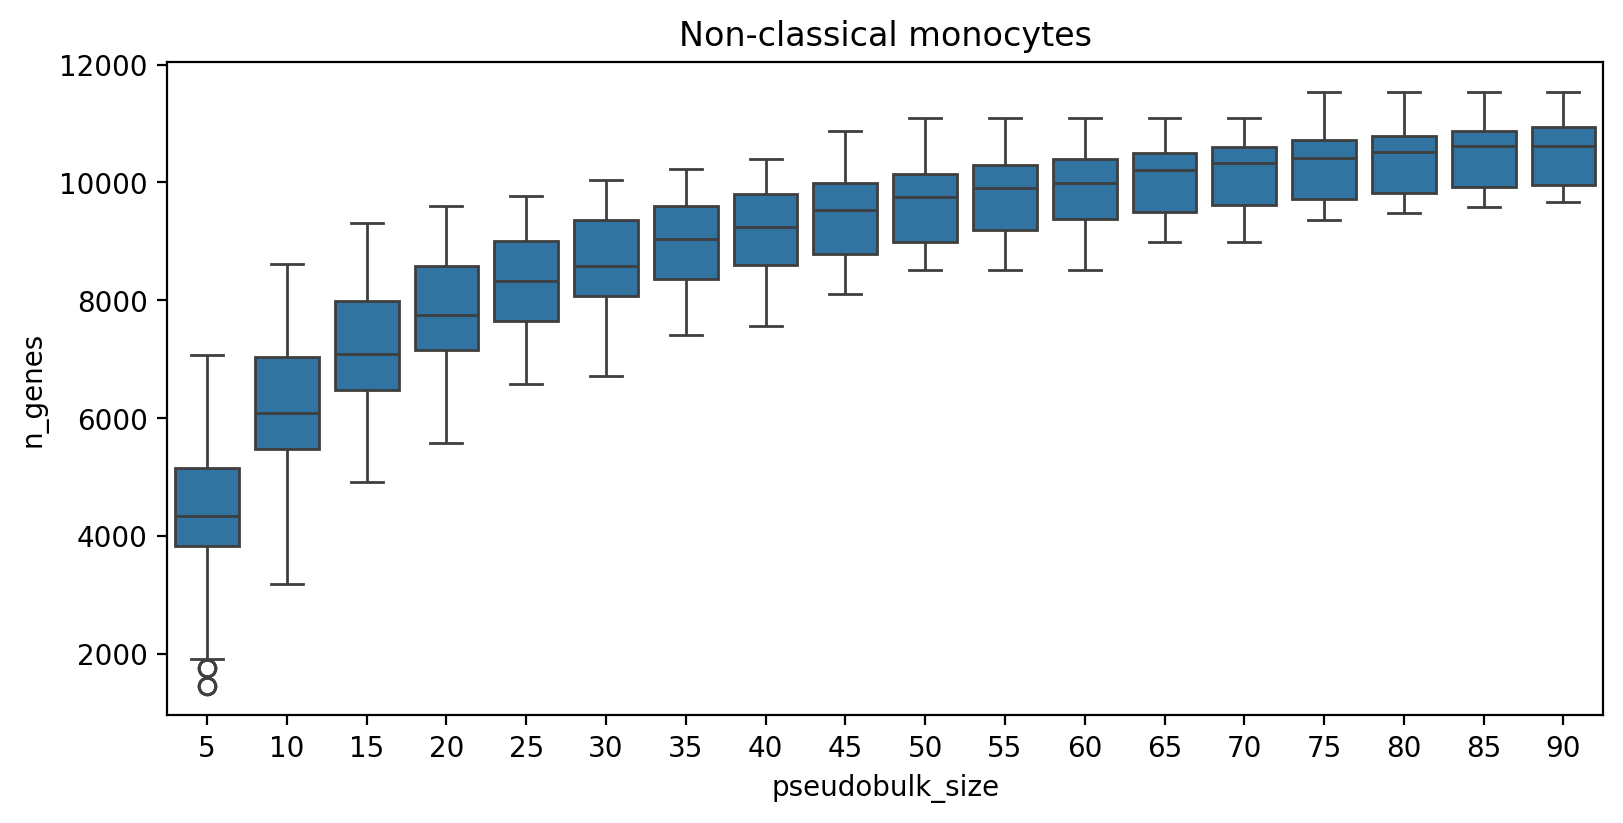

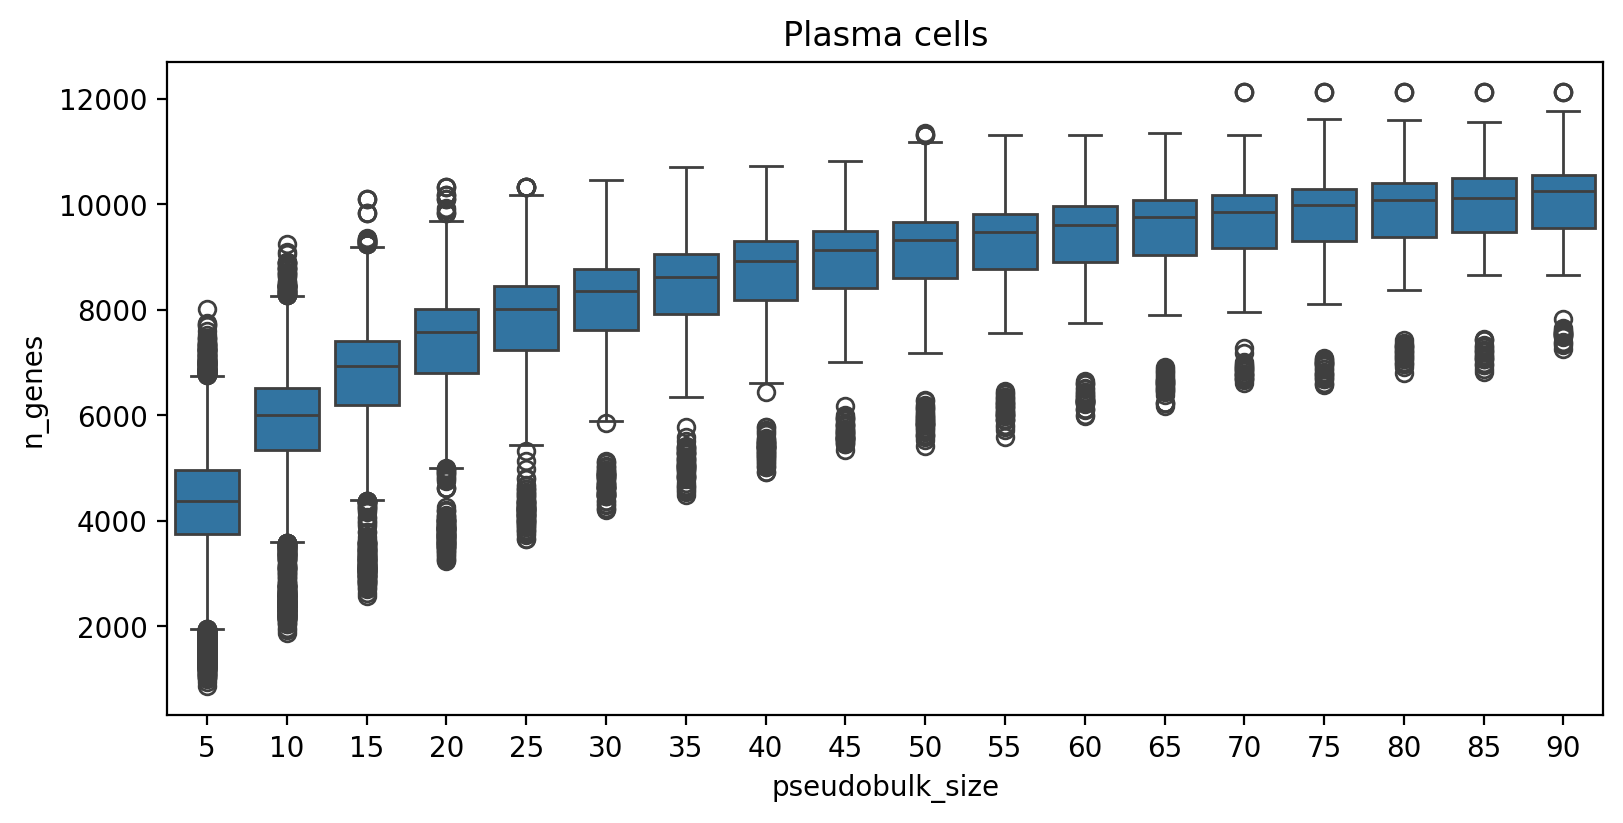

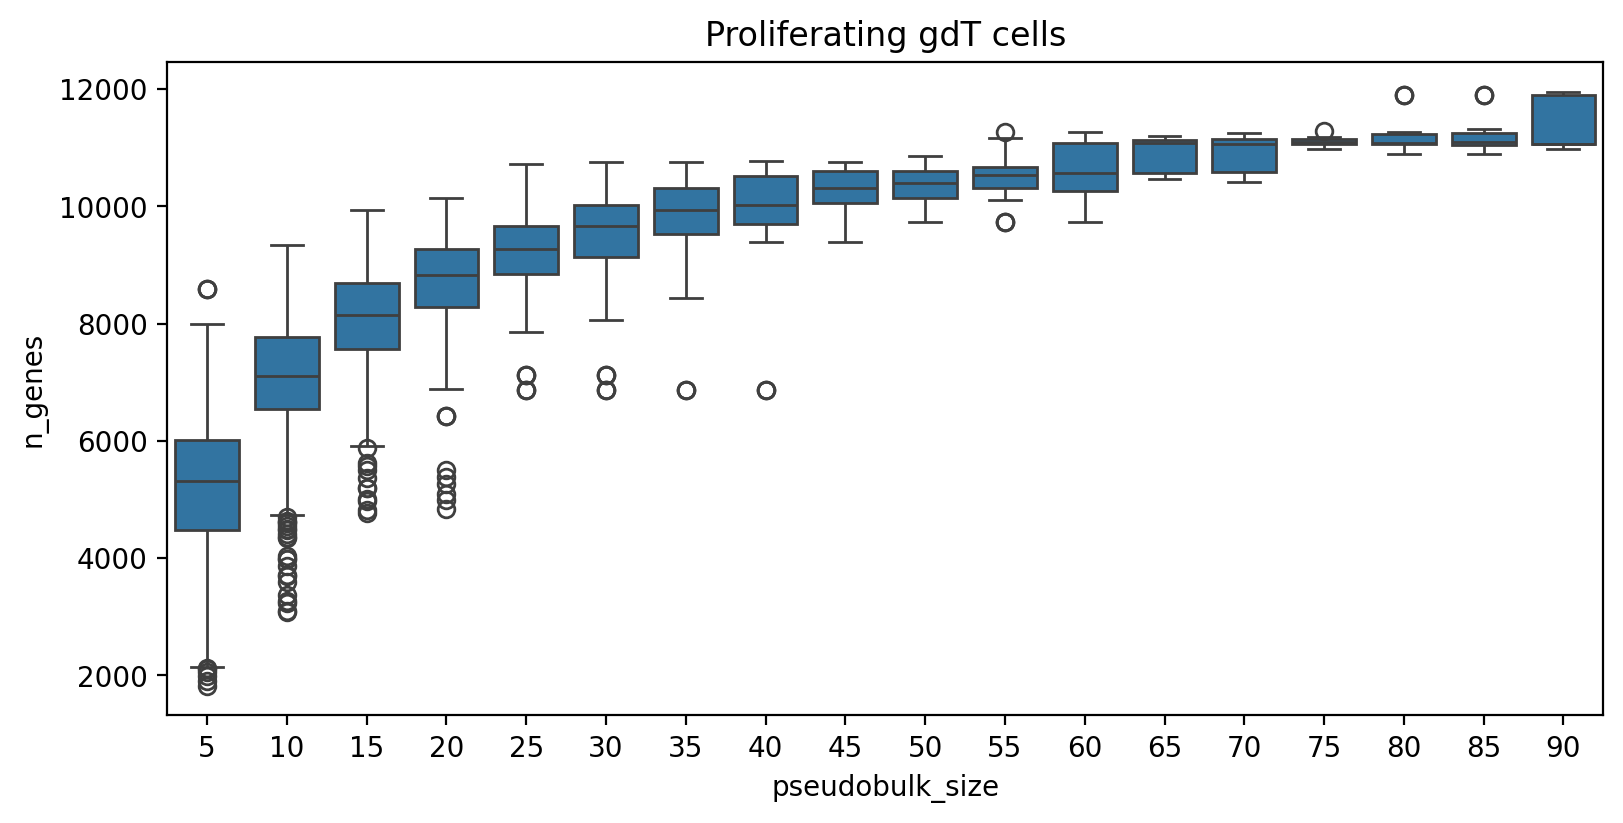

In [114]:
for ct in data.cell_type.unique():
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    sns.boxplot(data=data.loc[data.cell_type.eq(ct)], x='pseudobulk_size', y='n_genes', ax=ax)
    ax.set_title(ct)